# 🏙️ 서울시 상권 활력 지수 & 매출 예측 분석 (EDA)

## 📋 프로젝트 개요
- **목표**: 생활인구 데이터와 상권 매출 데이터 간의 상관관계 분석
- **핵심 질문**:
  1. 생활인구가 많을수록 매출이 높은가?
  2. 어떤 시간대/연령대가 매출에 가장 큰 영향을 미치는가?
  3. 경제 활력 지수로 핫존/콜드존을 찾을 수 있는가?
  4. AI로 매출을 예측할 수 있는가?

## 📊 사용 데이터
1. **processed_data.csv**: 상권 매출 데이터 (2020-2024)
2. **생활인구_전처리완료.csv**: 시간대별 생활인구 데이터 (2020)

---

## 1. 라이브러리 Import 및 기본 설정

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import platform
from scipy import stats
from scipy.stats import ttest_ind
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

# 시각화 기본 설정
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ 라이브러리 import 완료")
print(f"✅ 시스템: {platform.system()}")

✅ 라이브러리 import 완료
✅ 시스템: Darwin


In [2]:
# 한글 폰트 설정
if platform.system() == 'Darwin':  # macOS
    plt.rc('font', family='AppleGothic')
elif platform.system() == 'Windows':  # Windows
    plt.rc('font', family='Malgun Gothic')
else:  # other OS
    # Nanum font needs to be installed
    plt.rc('font', family='NanumGothic')

plt.rcParams['axes.unicode_minus'] = False # 마이너스 부호 깨짐 방지

## 2. 데이터 로드

In [3]:
print("📂 데이터 로딩 중...")

# 상권 매출 데이터
sales_df = pd.read_csv('data/processed_data.csv', encoding='utf-8-sig')
print(f"✅ 매출 데이터: {len(sales_df):,}개 행, {sales_df.shape[1]}개 칼럼")
print(f"   기간: {sales_df['YEAR'].min()}년 ~ {sales_df['YEAR'].max()}년")
print(f"   행정동 수: {sales_df['ADSTRD_CD'].nunique()}개")

# 생활인구 데이터
people_df = pd.read_csv('data/population/생활인구_전처리완료.csv', encoding='utf-8-sig')
print(f"\n✅ 생활인구 데이터: {len(people_df):,}개 행, {people_df.shape[1]}개 칼럼")
print(f"   기간: {people_df['연도'].min()}년 ~ {people_df['연도'].max()}년")
print(f"   행정동 수: {people_df['행정동코드'].nunique()}개")

# 메모리 사용량
print(f"\n💾 메모리 사용량:")
print(f"   매출 데이터: {sales_df.memory_usage(deep=True).sum() / 1024**2:.1f} MB")
print(f"   생활인구 데이터: {people_df.memory_usage(deep=True).sum() / 1024**2:.1f} MB")

📂 데이터 로딩 중...
✅ 매출 데이터: 434,199개 행, 35개 칼럼
   기간: 2020년 ~ 2024년
   행정동 수: 397개

✅ 생활인구 데이터: 8,480개 행, 14개 칼럼
   기간: 2020년 ~ 2024년
   행정동 수: 424개

💾 메모리 사용량:
   매출 데이터: 254.6 MB
   생활인구 데이터: 1.4 MB


In [4]:
# 데이터 확인
people_df.columns

Index(['행정동코드', '행정동명', '연도', '분기', '생활인구_TMZON_00_06_평균',
       '생활인구_TMZON_06_11_평균', '생활인구_TMZON_11_14_평균', '생활인구_TMZON_14_17_평균',
       '생활인구_TMZON_17_21_평균', '생활인구_TMZON_21_24_평균', '남성_20_60대_평균',
       '여성_20_60대_평균', '총생활인구_평균', '경제활동인구_평균'],
      dtype='object')

## 4. 데이터 전처리 및 병합 준비

In [5]:
print("🔧 데이터 전처리 중...")

# 매출 데이터: 행정동 코드를 문자열로 통일
sales_df['ADSTRD_CD'] = sales_df['ADSTRD_CD'].astype(str)

# 생활인구 데이터: 행정동 코드를 문자열로 통일
people_df['행정동코드'] = people_df['행정동코드'].astype(str)

# 칼럼명 통일을 위한 매핑
people_df_renamed = people_df.rename(columns={
    '행정동코드': 'ADSTRD_CD',
    '행정동명': 'ADSTRD_NM_POP',
    '연도': 'YEAR',
    '분기': 'QUARTER'
})

print(f"✅ 전처리 완료")
print(f"\n매출 데이터 행정동 코드 샘플: {sales_df['ADSTRD_CD'].head(3).tolist()}")
print(f"생활인구 데이터 행정동 코드 샘플: {people_df_renamed['ADSTRD_CD'].head(3).tolist()}")

🔧 데이터 전처리 중...
✅ 전처리 완료

매출 데이터 행정동 코드 샘플: ['11110560', '11110560', '11110560']
생활인구 데이터 행정동 코드 샘플: ['11110515', '11110515', '11110515']


## 5. 데이터 병합

**병합 키**: 행정동코드(ADSTRD_CD) + 연도(YEAR) + 분기(QUARTER)

2020-2024년 전체 데이터를 사용하여 매출 데이터와 생활인구 데이터를 병합합니다.

In [6]:
print("🔗 데이터 병합 중...")

# 전체 연도 매출 데이터 사용 (2020-2024)
print(f"매출 데이터: {len(sales_df):,}개 행")

# 행정동별, 연도별, 분기별로 집계 (업종별로 나뉘어 있으므로)
sales_agg = sales_df.groupby(['ADSTRD_CD', 'ADSTRD_NM', 'YEAR', 'QUARTER']).agg({
    'THSMON_SELNG_AMT': 'sum',  # 총 매출
    'MDWK_SELNG_AMT': 'sum',  # 평일 매출
    'WKEND_SELNG_AMT': 'sum',  # 주말 매출
    'TMZON_00_06_SELNG_AMT': 'sum',  # 시간대별 매출
    'TMZON_06_11_SELNG_AMT': 'sum',
    'TMZON_11_14_SELNG_AMT': 'sum',
    'TMZON_14_17_SELNG_AMT': 'sum',
    'TMZON_17_21_SELNG_AMT': 'sum',
    'TMZON_21_24_SELNG_AMT': 'sum',
    'ML_SELNG_AMT': 'sum',  # 남성 매출
    'FML_SELNG_AMT': 'sum',  # 여성 매출
    'AGRDE_20_SELNG_AMT': 'sum',  # 연령대별 매출
    'AGRDE_30_SELNG_AMT': 'sum',
    'AGRDE_40_SELNG_AMT': 'sum',
    'AGRDE_50_SELNG_AMT': 'sum',
    'AGRDE_60_ABOVE_SELNG_AMT': 'sum',
    'ECNMY_ACTIVE_POP_SELNG_AMT': 'sum'  # 경제활동인구 매출
}).reset_index()

print(f"집계 후 매출 데이터: {len(sales_agg):,}개 행")
print(f"연도별 집계:")
print(sales_agg.groupby('YEAR').size())

# 생활인구 데이터와 병합 (전체 연도!)
merged_df = sales_agg.merge(
    people_df_renamed,
    on=['ADSTRD_CD', 'YEAR', 'QUARTER'],
    how='inner'
)

print(f"\n✅ 병합 완료!")
print(f"   최종 데이터: {len(merged_df):,}개 행")
print(f"   연도: {sorted(merged_df['YEAR'].unique())}")
print(f"   행정동 수: {merged_df['ADSTRD_CD'].nunique()}개")
print(f"   분기 수: {merged_df['QUARTER'].nunique()}개")
print(f"\n연도별 데이터 분포:")
print(merged_df.groupby('YEAR').size())
print(f"\n샘플:")
print(merged_df.head(3))

🔗 데이터 병합 중...
매출 데이터: 434,199개 행
집계 후 매출 데이터: 7,936개 행
연도별 집계:
YEAR
2020    1584
2021    1588
2022    1588
2023    1588
2024    1588
dtype: int64

✅ 병합 완료!
   최종 데이터: 7,816개 행
   연도: [np.int64(2020), np.int64(2021), np.int64(2022), np.int64(2023), np.int64(2024)]
   행정동 수: 391개
   분기 수: 4개

연도별 데이터 분포:
YEAR
2020    1560
2021    1564
2022    1564
2023    1564
2024    1564
dtype: int64

샘플:
  ADSTRD_CD ADSTRD_NM  YEAR  QUARTER  THSMON_SELNG_AMT  MDWK_SELNG_AMT  \
0  11110515     청운효자동  2020        1        9197202266      7565934117   
1  11110515     청운효자동  2020        2       10700215089      8333502926   
2  11110515     청운효자동  2020        3       10441763619      8253957143   

   WKEND_SELNG_AMT  TMZON_00_06_SELNG_AMT  TMZON_06_11_SELNG_AMT  \
0       1631268149               16076665              682712866   
1       2366712163                8122643              380944744   
2       2187806476                9822400              380448362   

   TMZON_11_14_SELNG_AMT  ...  생활인구_TM

## 6. 기초 통계 분석

### 1) 기초 통계
##### 1-1) 매출 관련 통계

In [24]:
print("매출 관련 통계:")
sales_cols = ['THSMON_SELNG_AMT', 'ECNMY_ACTIVE_POP_SELNG_AMT']
print(merged_df[sales_cols].describe())

매출 관련 통계:
       THSMON_SELNG_AMT  ECNMY_ACTIVE_POP_SELNG_AMT
count      7.816000e+03                7.816000e+03
mean       5.431568e+10                4.784681e+10
std        1.125639e+11                9.516478e+10
min        1.480970e+06                1.480970e+06
25%        8.884478e+09                8.278068e+09
50%        1.943868e+10                1.818677e+10
75%        4.878016e+10                4.399888e+10
max        1.457274e+12                1.227643e+12


#### 1-2) 생활인구 관련 통계통계

In [25]:
print("생활인구 관련 통계")
population_cols = ['총생활인구_평균', '경제활동인구_평균','남성_20_60대_평균','여성_20_60대_평균']
print(merged_df[population_cols].describe())

생활인구 관련 통계
            총생활인구_평균      경제활동인구_평균  남성_20_60대_평균  여성_20_60대_평균
count    7816.000000    7816.000000   7816.000000   7816.000000
mean    24773.252943   18476.868603   8886.572160   9590.296443
std     12907.967817   10627.974980   5489.018088   5236.561325
min      2716.000000    2050.000000   1061.000000    989.000000
25%     16190.250000   11598.500000   5434.000000   6133.250000
50%     21921.500000   16083.500000   7630.000000   8431.000000
75%     30799.500000   22607.250000  10702.250000  11787.000000
max    115771.000000  103187.000000  54689.000000  48801.000000


##### 1-3) 주요 상관관계 지표 계산

In [26]:
print("주요 상관관계 지표:")
merged_df['1인당_평균매출'] = merged_df['THSMON_SELNG_AMT'] / merged_df['총생활인구_평균']
merged_df['경제활동인구_1인당매출'] = merged_df['ECNMY_ACTIVE_POP_SELNG_AMT'] / merged_df['경제활동인구_평균']

print(f"  1인당 평균매출 중앙값: {merged_df['1인당_평균매출'].median():,.0f}원")
print(f"  경제활동인구 1인당매출 중앙값: {merged_df['경제활동인구_1인당매출'].median():,.0f}원")

주요 상관관계 지표:
  1인당 평균매출 중앙값: 957,743원
  경제활동인구 1인당매출 중앙값: 1,197,457원


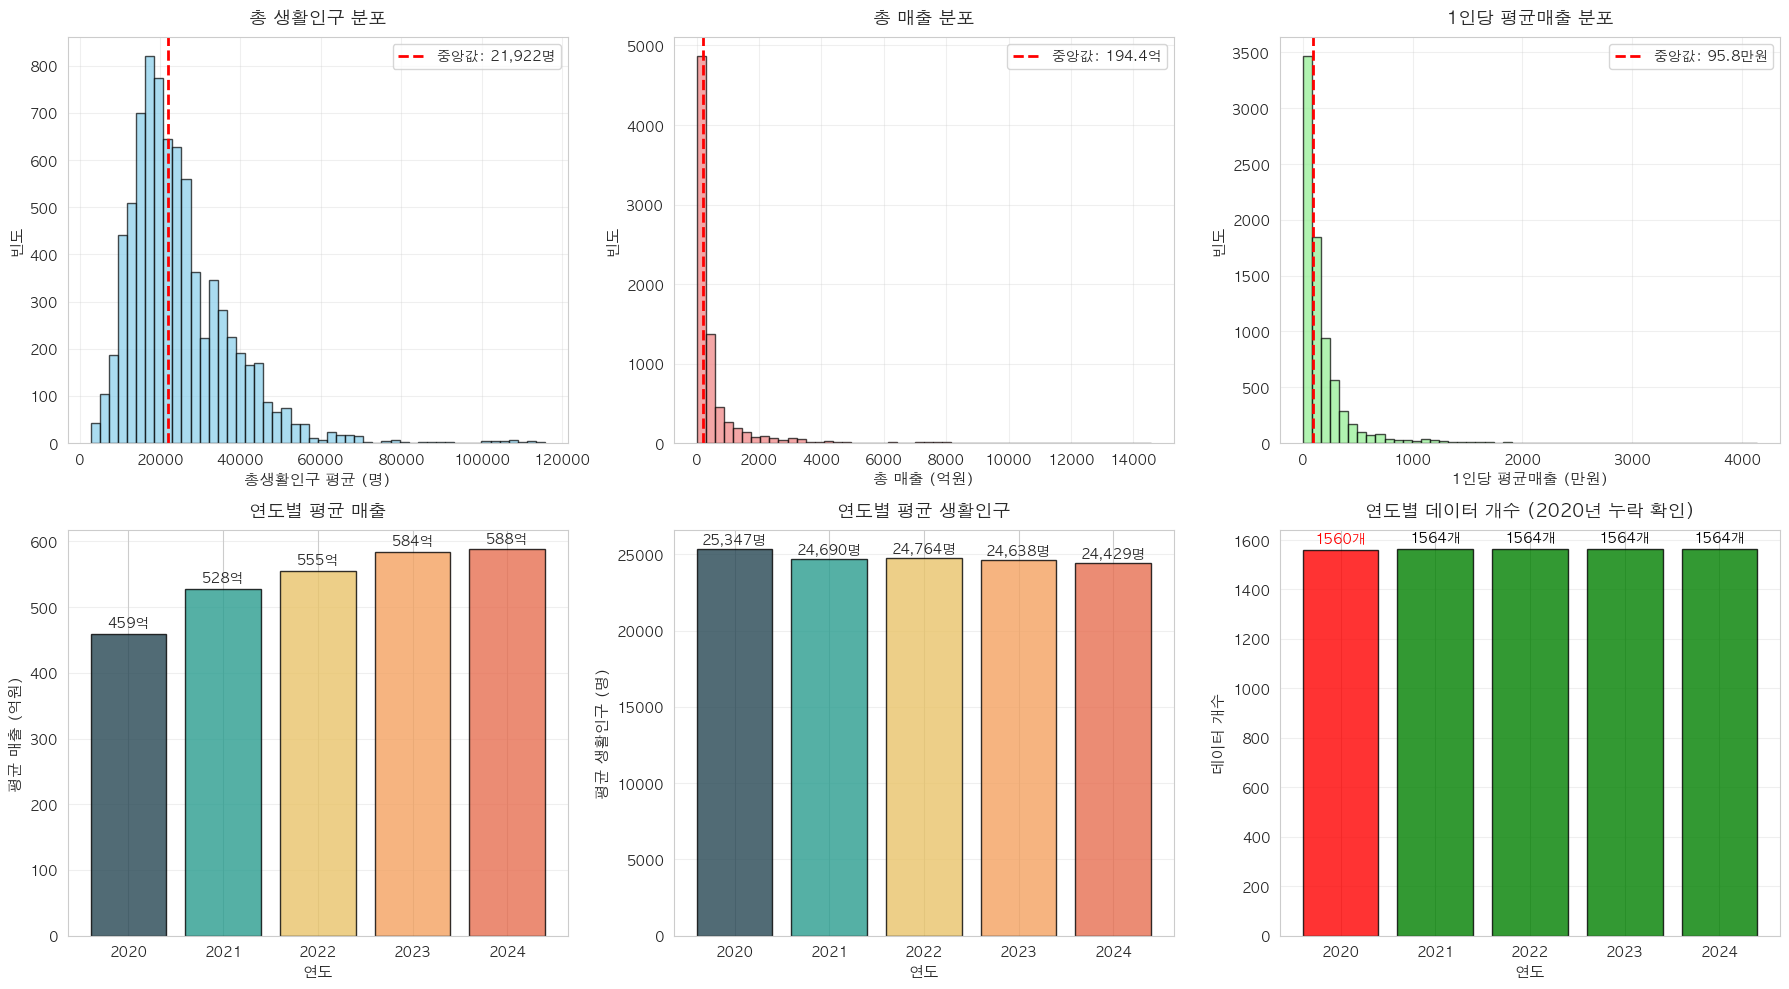

In [28]:
# 시각화 1: 생활인구 vs 매출 분포 비교
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# 1-1. 총생활인구 분포
ax1 = axes[0, 0]
ax1.hist(merged_df['총생활인구_평균'], bins=50, color='skyblue', edgecolor='black', alpha=0.7)
ax1.set_xlabel('총생활인구 평균 (명)', fontsize=11, weight='bold')
ax1.set_ylabel('빈도', fontsize=11, weight='bold')
ax1.set_title('총 생활인구 분포', fontsize=13, weight='bold', pad=10)
ax1.axvline(merged_df['총생활인구_평균'].median(), color='red', linestyle='--', linewidth=2,
            label=f'중앙값: {merged_df["총생활인구_평균"].median():,.0f}명')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# 1-2. 총매출 분포
ax2 = axes[0, 1]
ax2.hist(merged_df['THSMON_SELNG_AMT'] / 1e8, bins=50, color='lightcoral', edgecolor='black', alpha=0.7)
ax2.set_xlabel('총 매출 (억원)', fontsize=11, weight='bold')
ax2.set_ylabel('빈도', fontsize=11, weight='bold')
ax2.set_title('총 매출 분포', fontsize=13, weight='bold', pad=10)
ax2.axvline(merged_df['THSMON_SELNG_AMT'].median() / 1e8, color='red', linestyle='--', linewidth=2,
            label=f'중앙값: {merged_df["THSMON_SELNG_AMT"].median()/1e8:.1f}억')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

# 1-3. 1인당 평균매출 분포
ax3 = axes[0, 2]
ax3.hist(merged_df['1인당_평균매출'] / 1e4, bins=50, color='lightgreen', edgecolor='black', alpha=0.7)
ax3.set_xlabel('1인당 평균매출 (만원)', fontsize=11, weight='bold')
ax3.set_ylabel('빈도', fontsize=11, weight='bold')
ax3.set_title('1인당 평균매출 분포', fontsize=13, weight='bold', pad=10)
ax3.axvline(merged_df['1인당_평균매출'].median() / 1e4, color='red', linestyle='--', linewidth=2,
            label=f'중앙값: {merged_df["1인당_평균매출"].median()/1e4:.1f}만원')
ax3.legend(fontsize=10)
ax3.grid(True, alpha=0.3)

# 2-1. 연도별 평균 매출
ax4 = axes[1, 0]
yearly_sales = merged_df.groupby('YEAR')['THSMON_SELNG_AMT'].mean() / 1e8
ax4.bar(yearly_sales.index, yearly_sales.values, color=['#264653', '#2A9D8F', '#E9C46A', '#F4A261', '#E76F51'],
        edgecolor='black', alpha=0.8)
ax4.set_xlabel('연도', fontsize=11, weight='bold')
ax4.set_ylabel('평균 매출 (억원)', fontsize=11, weight='bold')
ax4.set_title('연도별 평균 매출', fontsize=13, weight='bold', pad=10)
ax4.set_xticks(yearly_sales.index)
for i, (year, val) in enumerate(yearly_sales.items()):
    ax4.text(year, val + 5, f'{val:.0f}억', ha='center', va='bottom', fontsize=10, weight='bold')
ax4.grid(True, alpha=0.3, axis='y')

# 2-2. 연도별 평균 생활인구
ax5 = axes[1, 1]
yearly_pop = merged_df.groupby('YEAR')['총생활인구_평균'].mean()
ax5.bar(yearly_pop.index, yearly_pop.values, color=['#264653', '#2A9D8F', '#E9C46A', '#F4A261', '#E76F51'],
        edgecolor='black', alpha=0.8)
ax5.set_xlabel('연도', fontsize=11, weight='bold')
ax5.set_ylabel('평균 생활인구 (명)', fontsize=11, weight='bold')
ax5.set_title('연도별 평균 생활인구', fontsize=13, weight='bold', pad=10)
ax5.set_xticks(yearly_pop.index)
for i, (year, val) in enumerate(yearly_pop.items()):
    ax5.text(year, val + 100, f'{val:,.0f}명', ha='center', va='bottom', fontsize=10, weight='bold')
ax5.grid(True, alpha=0.3, axis='y')

# 2-3. 연도별 데이터 개수
ax6 = axes[1, 2]
yearly_count = merged_df.groupby('YEAR').size()
colors_count = ['red' if cnt < yearly_count.max() else 'green' for cnt in yearly_count.values]
ax6.bar(yearly_count.index, yearly_count.values, color=colors_count, edgecolor='black', alpha=0.8)
ax6.set_xlabel('연도', fontsize=11, weight='bold')
ax6.set_ylabel('데이터 개수', fontsize=11, weight='bold')
ax6.set_title('연도별 데이터 개수 (2020년 누락 확인)', fontsize=13, weight='bold', pad=10)
ax6.set_xticks(yearly_count.index)
for i, (year, val) in enumerate(yearly_count.items()):
    color = 'red' if val < yearly_count.max() else 'black'
    ax6.text(year, val + 20, f'{val}개', ha='center', va='bottom', fontsize=10, weight='bold', color=color)
ax6.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()



In [29]:
# 연도별 평균 통계 테이블
print("\n📅 연도별 평균 매출 및 생활인구:")
yearly_stats = merged_df.groupby('YEAR').agg({
    'THSMON_SELNG_AMT': 'mean',
    '총생활인구_평균': 'mean',
    '경제활동인구_평균': 'mean',
    'ADSTRD_CD': 'count'  # 데이터 개수
}).round(0)
yearly_stats.columns = ['평균_총매출', '평균_총생활인구', '평균_경제활동인구', '데이터개수']
yearly_stats['평균_총매출_억'] = (yearly_stats['평균_총매출'] / 1e8).round(1)
print(yearly_stats[['평균_총매출_억', '평균_총생활인구', '평균_경제활동인구', '데이터개수']])

# 전년 대비 증가율
print("\n📊 전년 대비 증가율:")
yearly_stats['매출_증가율_%'] = yearly_stats['평균_총매출'].pct_change() * 100
yearly_stats['인구_증가율_%'] = yearly_stats['평균_총생활인구'].pct_change() * 100
print(yearly_stats[['매출_증가율_%', '인구_증가율_%']].round(2))

# 2020년 데이터 누락 분석
print("\n⚠️  2020년 데이터 누락 분석:")
print(f"  2020년: {yearly_count[2020]}개 (예상 대비 -{yearly_count.max() - yearly_count[2020]}개 부족)")
print(f"  2021-2024년: 각 {yearly_count.max()}개")
print(f"  → 2020년 1분기 일부 행정동 데이터 누락 가능성")

# 분기별 평균
print("\n📅 분기별 평균 매출 및 생활인구:")
quarterly_stats = merged_df.groupby('QUARTER').agg({
    'THSMON_SELNG_AMT': 'mean',
    '총생활인구_평균': 'mean',
    '경제활동인구_평균': 'mean'
}).round(0)
quarterly_stats.columns = ['평균_총매출', '평균_총생활인구', '평균_경제활동인구']
quarterly_stats['평균_총매출_억'] = (quarterly_stats['평균_총매출'] / 1e8).round(1)
print(quarterly_stats[['평균_총매출_억', '평균_총생활인구', '평균_경제활동인구']])


📅 연도별 평균 매출 및 생활인구:
      평균_총매출_억  평균_총생활인구  평균_경제활동인구  데이터개수
YEAR                                      
2020     459.4   25347.0    18887.0   1560
2021     528.1   24690.0    18419.0   1564
2022     555.4   24764.0    18470.0   1564
2023     584.2   24638.0    18387.0   1564
2024     588.4   24429.0    18222.0   1564

📊 전년 대비 증가율:
      매출_증가율_%  인구_증가율_%
YEAR                    
2020       NaN       NaN
2021     14.94     -2.59
2022      5.19      0.30
2023      5.18     -0.51
2024      0.72     -0.85

⚠️  2020년 데이터 누락 분석:
  2020년: 1560개 (예상 대비 -4개 부족)
  2021-2024년: 각 1564개
  → 2020년 1분기 일부 행정동 데이터 누락 가능성

📅 분기별 평균 매출 및 생활인구:
         평균_총매출_억  평균_총생활인구  평균_경제활동인구
QUARTER                               
1           519.5   24964.0    18617.0
2           543.1   24914.0    18569.0
3           538.1   24509.0    18280.0
4           572.0   24707.0    18443.0


### 7.3 시계열 분석 (2020-2024 트렌드)

**COVID-19 영향 분석 포함**
- 2020: 코로나 시작
- 2021-2022: 거리두기 시행
- 2023-2024: 일상 회복

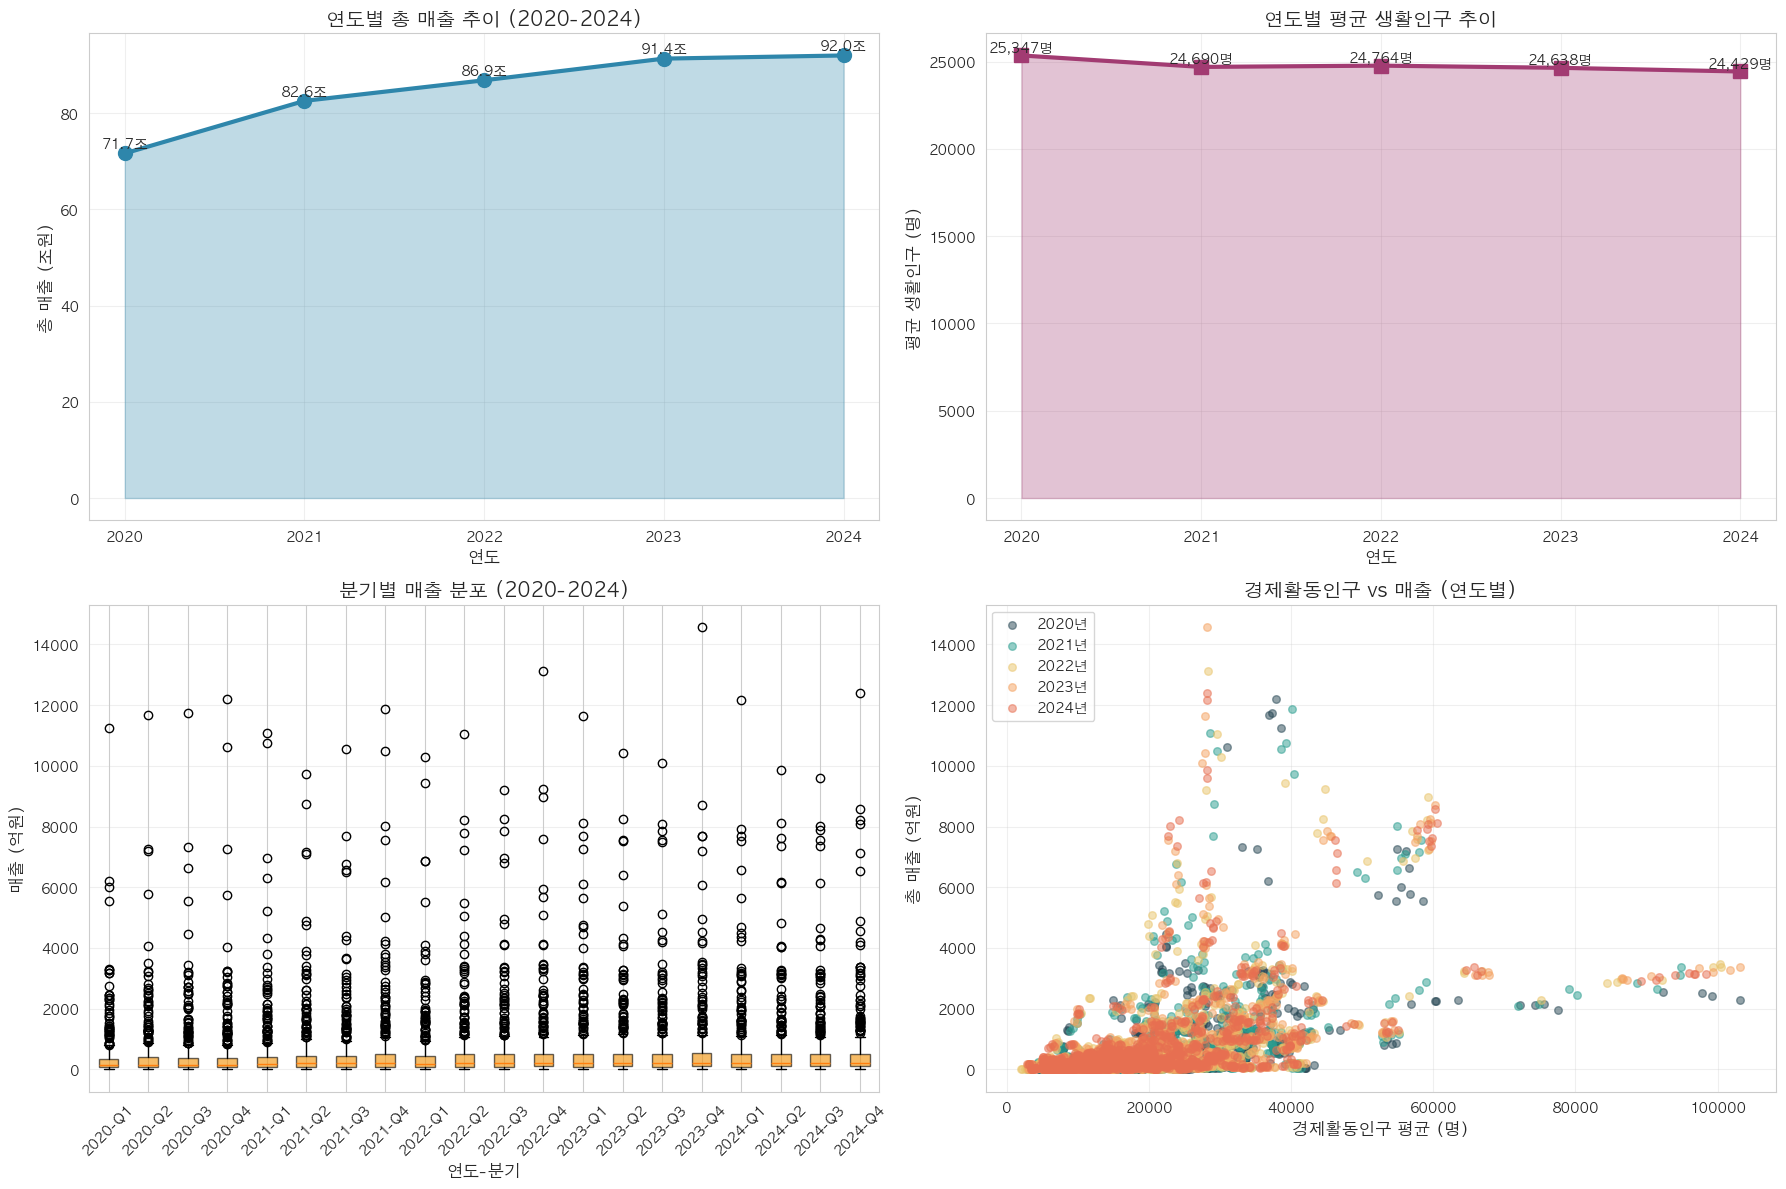


📊 연도별 주요 지표 요약:
      총매출_조원          평균매출  평균_생활인구  평균_경제활동인구  데이터수
YEAR                                                
2020   71.67  4.594136e+10  25347.0    18887.0  1560
2021   82.59  5.280550e+10  24690.0    18419.0  1564
2022   86.87  5.554374e+10  24764.0    18470.0  1564
2023   91.37  5.842328e+10  24638.0    18387.0  1564
2024   92.03  5.884311e+10  24429.0    18222.0  1564


In [8]:
# 연도별 매출 및 생활인구 트렌드
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# 1. 연도별 총 매출 추이
ax1 = axes[0, 0]
yearly_sales = merged_df.groupby('YEAR')['THSMON_SELNG_AMT'].sum() / 1e12
ax1.plot(yearly_sales.index, yearly_sales.values, marker='o', linewidth=3, markersize=10, color='#2E86AB')
ax1.fill_between(yearly_sales.index, yearly_sales.values, alpha=0.3, color='#2E86AB')
ax1.set_xlabel('연도', fontsize=12)
ax1.set_ylabel('총 매출 (조원)', fontsize=12)
ax1.set_title('연도별 총 매출 추이 (2020-2024)', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.set_xticks(yearly_sales.index)

# 각 점에 값 표시
for x, y in zip(yearly_sales.index, yearly_sales.values):
    ax1.text(x, y + 0.5, f'{y:.1f}조', ha='center', va='bottom', fontsize=10, fontweight='bold')

# 2. 연도별 평균 생활인구 추이
ax2 = axes[0, 1]
yearly_pop = merged_df.groupby('YEAR')['총생활인구_평균'].mean()
ax2.plot(yearly_pop.index, yearly_pop.values, marker='s', linewidth=3, markersize=10, color='#A23B72')
ax2.fill_between(yearly_pop.index, yearly_pop.values, alpha=0.3, color='#A23B72')
ax2.set_xlabel('연도', fontsize=12)
ax2.set_ylabel('평균 생활인구 (명)', fontsize=12)
ax2.set_title('연도별 평균 생활인구 추이', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.set_xticks(yearly_pop.index)

for x, y in zip(yearly_pop.index, yearly_pop.values):
    ax2.text(x, y + 50, f'{y:,.0f}명', ha='center', va='bottom', fontsize=10, fontweight='bold')

# 3. 분기별 매출 박스플롯 (연도별)
ax3 = axes[1, 0]
merged_df['YEAR_Q'] = merged_df['YEAR'].astype(str) + '-Q' + merged_df['QUARTER'].astype(str)
quarter_order = sorted(merged_df['YEAR_Q'].unique())
quarter_data = [merged_df[merged_df['YEAR_Q'] == q]['THSMON_SELNG_AMT'].values / 1e8
                for q in quarter_order]

bp = ax3.boxplot(quarter_data, labels=quarter_order, patch_artist=True)
for patch in bp['boxes']:
    patch.set_facecolor('#F18F01')
    patch.set_alpha(0.6)

ax3.set_xlabel('연도-분기', fontsize=12)
ax3.set_ylabel('매출 (억원)', fontsize=12)
ax3.set_title('분기별 매출 분포 (2020-2024)', fontsize=14, fontweight='bold')
ax3.tick_params(axis='x', rotation=45)
ax3.grid(True, alpha=0.3, axis='y')

# 4. 경제활동인구 vs 매출 상관관계 (연도별)
ax4 = axes[1, 1]
colors_year = ['#264653', '#2A9D8F', '#E9C46A', '#F4A261', '#E76F51']
for idx, year in enumerate(sorted(merged_df['YEAR'].unique())):
    year_data = merged_df[merged_df['YEAR'] == year]
    ax4.scatter(year_data['경제활동인구_평균'], year_data['THSMON_SELNG_AMT'] / 1e8,
                alpha=0.5, s=30, label=f'{year}년', color=colors_year[idx])

ax4.set_xlabel('경제활동인구 평균 (명)', fontsize=12)
ax4.set_ylabel('총 매출 (억원)', fontsize=12)
ax4.set_title('경제활동인구 vs 매출 (연도별)', fontsize=14, fontweight='bold')
ax4.legend(loc='upper left', fontsize=10)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 연도별 주요 지표 요약:")
print("="*80)
summary_by_year = merged_df.groupby('YEAR').agg({
    'THSMON_SELNG_AMT': ['sum', 'mean'],
    '총생활인구_평균': 'mean',
    '경제활동인구_평균': 'mean',
    'ADSTRD_CD': 'count'
}).round(0)
summary_by_year.columns = ['총매출_합계', '평균매출', '평균_생활인구', '평균_경제활동인구', '데이터수']
summary_by_year['총매출_조원'] = (summary_by_year['총매출_합계'] / 1e12).round(2)
print(summary_by_year[['총매출_조원', '평균매출', '평균_생활인구', '평균_경제활동인구', '데이터수']])

### 7.4 코로나 전후 비교 분석

🦠 코로나 전후 비교 분석

📊 기간별 평균 지표:
                   THSMON_SELNG_AMT  총생활인구_평균  경제활동인구_평균  MDWK_SELNG_AMT  \
period                                                                     
거리두기 (2021-2022)       5.417462e+10   24727.0    18444.0    4.090179e+10   
일상 회복 (2023-2024)      5.863319e+10   24533.0    18305.0    4.440021e+10   
코로나 초기 (2020)          4.594136e+10   25347.0    18887.0    3.492502e+10   

                   WKEND_SELNG_AMT  
period                              
거리두기 (2021-2022)      1.327283e+10  
일상 회복 (2023-2024)     1.423298e+10  
코로나 초기 (2020)         1.101634e+10  


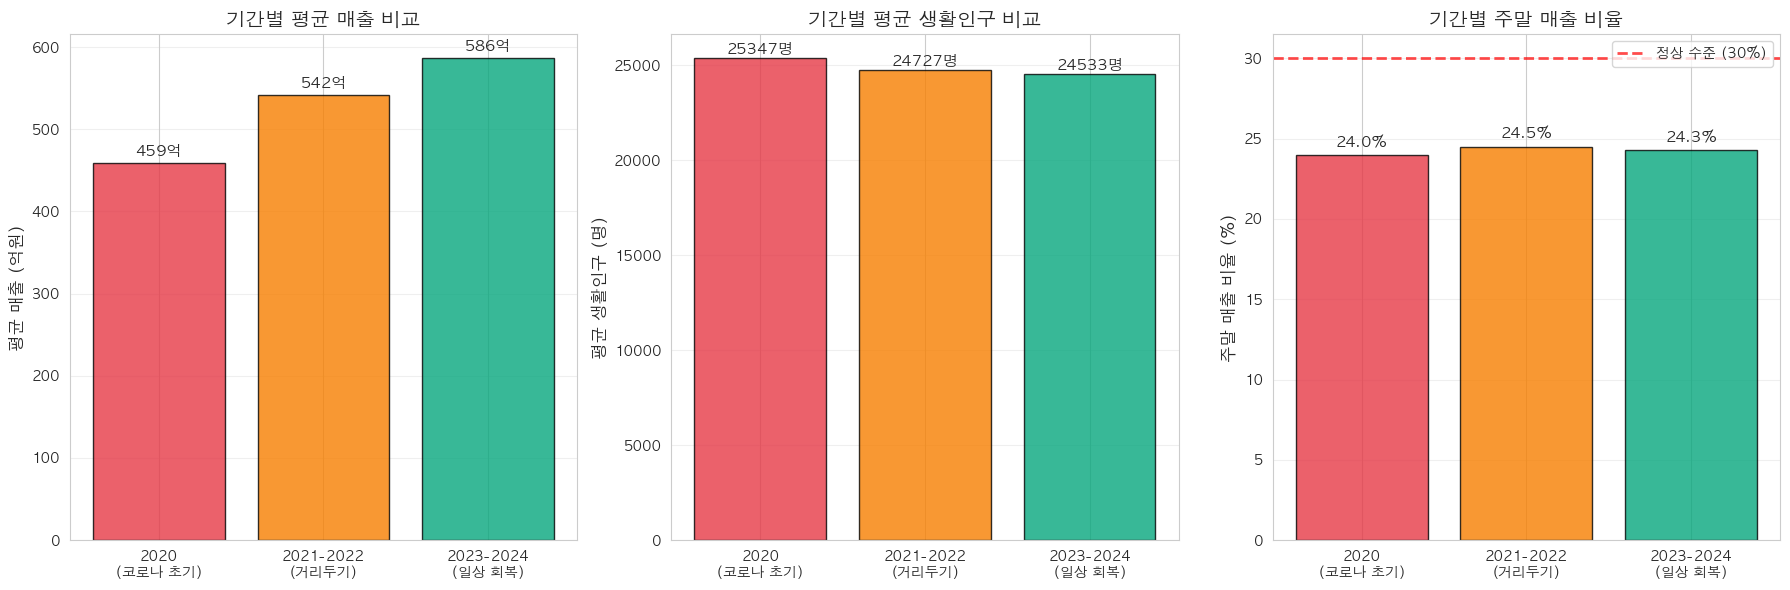


📊 통계적 검정 (2020 vs 2023-2024):
   t-통계량: -3.627
   p-value: 0.000289
   ✅ 통계적으로 유의미한 차이 있음 (p < 0.05)

📈 매출 회복률:
   2020년 평균: 459.4억원
   2023-2024년 평균: 586.3억원
   회복률: +27.6%


In [9]:
print("🦠 코로나 전후 비교 분석")
print("="*80)

# 3개 기간으로 구분
merged_df['period'] = merged_df['YEAR'].apply(lambda x:
    '코로나 초기 (2020)' if x == 2020 else
    '거리두기 (2021-2022)' if x in [2021, 2022] else
    '일상 회복 (2023-2024)')

# 기간별 통계
period_stats = merged_df.groupby('period').agg({
    'THSMON_SELNG_AMT': 'mean',
    '총생활인구_평균': 'mean',
    '경제활동인구_평균': 'mean',
    # '야간매출': 'mean',
    'MDWK_SELNG_AMT': 'mean',
    'WKEND_SELNG_AMT': 'mean'
}).round(0)

print("\n📊 기간별 평균 지표:")
print(period_stats)

# 시각화
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# 1. 기간별 평균 매출 비교
ax1 = axes[0]
period_order = ['코로나 초기 (2020)', '거리두기 (2021-2022)', '일상 회복 (2023-2024)']
period_sales = [period_stats.loc[p, 'THSMON_SELNG_AMT'] / 1e8 for p in period_order]
colors_period = ['#E63946', '#F77F00', '#06A77D']
bars1 = ax1.bar(range(3), period_sales, color=colors_period, edgecolor='black', alpha=0.8)
ax1.set_xticks(range(3))
ax1.set_xticklabels(['2020\n(코로나 초기)', '2021-2022\n(거리두기)', '2023-2024\n(일상 회복)'])
ax1.set_ylabel('평균 매출 (억원)', fontsize=12)
ax1.set_title('기간별 평균 매출 비교', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='y')

for bar, val in zip(bars1, period_sales):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5,
             f'{val:.0f}억', ha='center', va='bottom', fontsize=11, fontweight='bold')

# 2. 기간별 생활인구 비교
ax2 = axes[1]
period_pop = [period_stats.loc[p, '총생활인구_평균'] for p in period_order]
bars2 = ax2.bar(range(3), period_pop, color=colors_period, edgecolor='black', alpha=0.8)
ax2.set_xticks(range(3))
ax2.set_xticklabels(['2020\n(코로나 초기)', '2021-2022\n(거리두기)', '2023-2024\n(일상 회복)'])
ax2.set_ylabel('평균 생활인구 (명)', fontsize=12)
ax2.set_title('기간별 평균 생활인구 비교', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')

for bar, val in zip(bars2, period_pop):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50,
             f'{val:.0f}명', ha='center', va='bottom', fontsize=11, fontweight='bold')

# 3. 주중/주말 매출 비율 변화
ax3 = axes[2]
period_weekend_ratio = [(period_stats.loc[p, 'WKEND_SELNG_AMT'] /
                        (period_stats.loc[p, 'MDWK_SELNG_AMT'] + period_stats.loc[p, 'WKEND_SELNG_AMT']) * 100)
                        for p in period_order]
bars3 = ax3.bar(range(3), period_weekend_ratio, color=colors_period, edgecolor='black', alpha=0.8)
ax3.set_xticks(range(3))
ax3.set_xticklabels(['2020\n(코로나 초기)', '2021-2022\n(거리두기)', '2023-2024\n(일상 회복)'])
ax3.set_ylabel('주말 매출 비율 (%)', fontsize=12)
ax3.set_title('기간별 주말 매출 비율', fontsize=14, fontweight='bold')
ax3.axhline(30, color='red', linestyle='--', linewidth=2, alpha=0.7, label='정상 수준 (30%)')
ax3.legend()
ax3.grid(True, alpha=0.3, axis='y')

for bar, val in zip(bars3, period_weekend_ratio):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3,
             f'{val:.1f}%', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

# 통계적 유의성 검정 (t-test)
from scipy.stats import ttest_ind

covid_sales = merged_df[merged_df['YEAR'] == 2020]['THSMON_SELNG_AMT']
recovery_sales = merged_df[merged_df['YEAR'].isin([2023, 2024])]['THSMON_SELNG_AMT']

t_stat, p_value = ttest_ind(covid_sales, recovery_sales)

print(f"\n📊 통계적 검정 (2020 vs 2023-2024):")
print(f"   t-통계량: {t_stat:.3f}")
print(f"   p-value: {p_value:.6f}")
if p_value < 0.05:
    print(f"   ✅ 통계적으로 유의미한 차이 있음 (p < 0.05)")
else:
    print(f"   ❌ 통계적으로 유의미한 차이 없음 (p >= 0.05)")

# 회복률 계산
covid_avg = covid_sales.mean()
recovery_avg = recovery_sales.mean()
recovery_rate = ((recovery_avg - covid_avg) / covid_avg) * 100

print(f"\n📈 매출 회복률:")
print(f"   2020년 평균: {covid_avg/1e8:.1f}억원")
print(f"   2023-2024년 평균: {recovery_avg/1e8:.1f}억원")
print(f"   회복률: {recovery_rate:+.1f}%")

In [10]:
print("📈 기초 통계")
print("="*80)

# 매출 통계
print("\n💰 매출 관련 통계:")
sales_cols = ['THSMON_SELNG_AMT', 'ECNMY_ACTIVE_POP_SELNG_AMT']
print(merged_df[sales_cols].describe())

# 생활인구 통계
print("\n👥 생활인구 관련 통계:")
pop_cols = ['총생활인구_평균', '경제활동인구_평균', '남성_20_60대_평균', '여성_20_60대_평균']
print(merged_df[pop_cols].describe())

# 분기별 평균
print("\n📅 분기별 평균 매출 및 생활인구:")
quarterly_stats = merged_df.groupby('QUARTER').agg({
    'THSMON_SELNG_AMT': 'mean',
    '총생활인구_평균': 'mean',
    '경제활동인구_평균': 'mean'
}).round(0)
quarterly_stats.columns = ['평균_총매출', '평균_총생활인구', '평균_경제활동인구']
print(quarterly_stats)

📈 기초 통계

💰 매출 관련 통계:
       THSMON_SELNG_AMT  ECNMY_ACTIVE_POP_SELNG_AMT
count      7.816000e+03                7.816000e+03
mean       5.431568e+10                4.784681e+10
std        1.125639e+11                9.516478e+10
min        1.480970e+06                1.480970e+06
25%        8.884478e+09                8.278068e+09
50%        1.943868e+10                1.818677e+10
75%        4.878016e+10                4.399888e+10
max        1.457274e+12                1.227643e+12

👥 생활인구 관련 통계:
            총생활인구_평균      경제활동인구_평균  남성_20_60대_평균  여성_20_60대_평균
count    7816.000000    7816.000000   7816.000000   7816.000000
mean    24773.252943   18476.868603   8886.572160   9590.296443
std     12907.967817   10627.974980   5489.018088   5236.561325
min      2716.000000    2050.000000   1061.000000    989.000000
25%     16190.250000   11598.500000   5434.000000   6133.250000
50%     21921.500000   16083.500000   7630.000000   8431.000000
75%     30799.500000   22607.250000  10702.25000

## 7. 상관관계 분석

### 7.1 전체 상관계수 매트릭스

🔍 상관관계 분석 중...


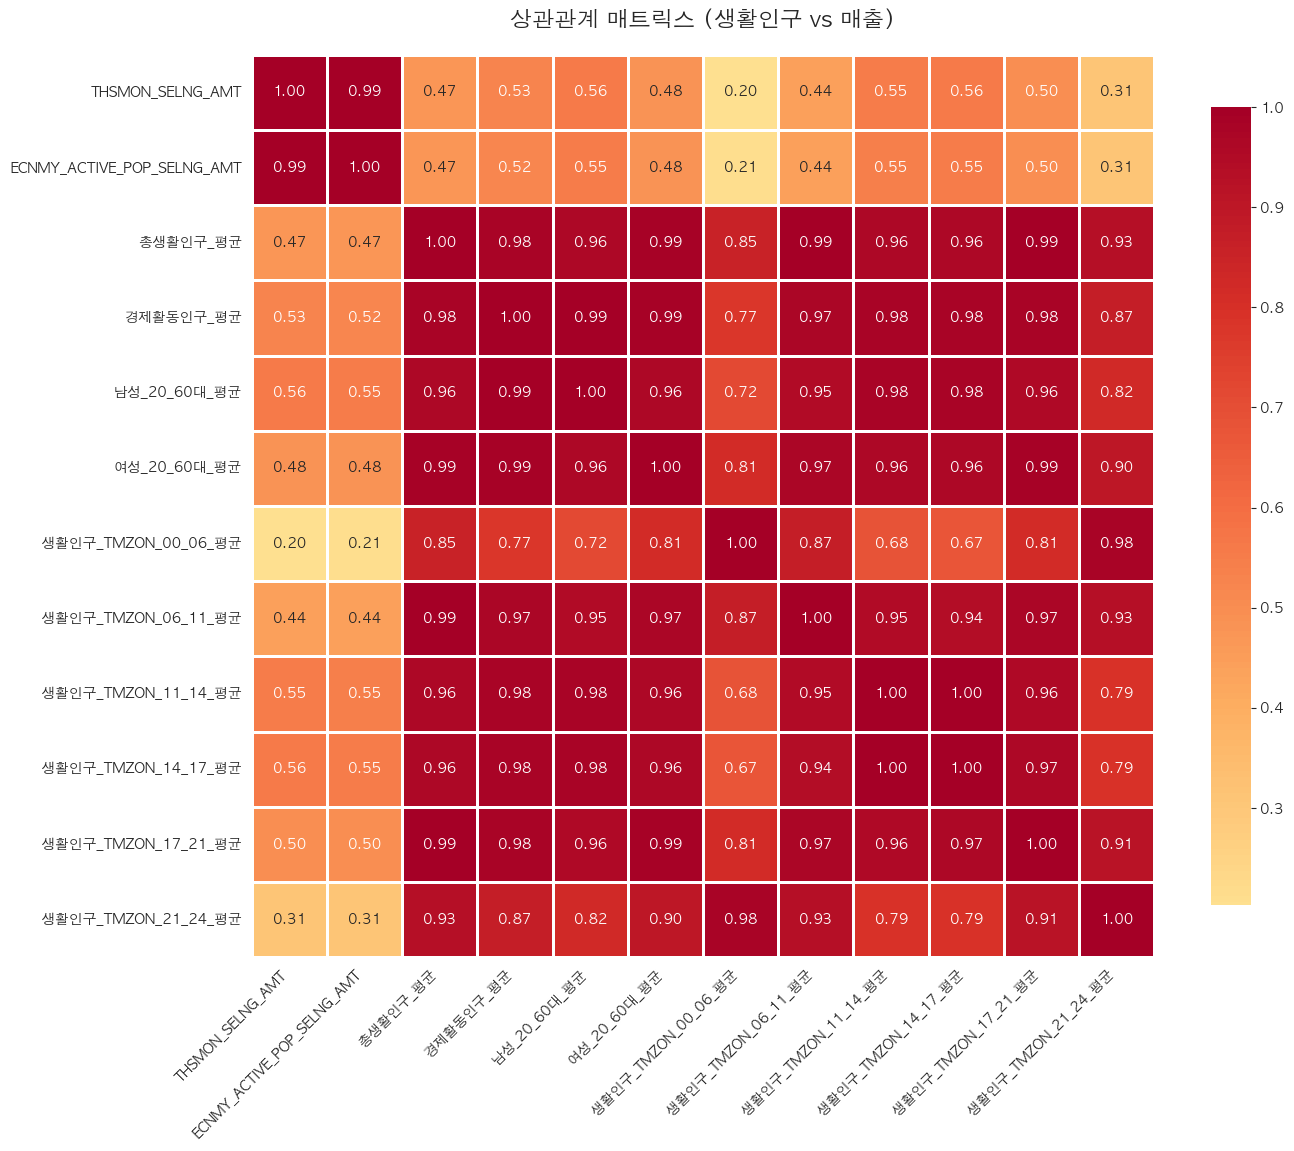


💡 총 매출(THSMON_SELNG_AMT)과의 상관계수:
ECNMY_ACTIVE_POP_SELNG_AMT              :  0.992
생활인구_TMZON_14_17_평균                     :  0.557
남성_20_60대_평균                            :  0.556
생활인구_TMZON_11_14_평균                     :  0.552
경제활동인구_평균                               :  0.525
생활인구_TMZON_17_21_평균                     :  0.497
여성_20_60대_평균                            :  0.484
총생활인구_평균                                :  0.472
생활인구_TMZON_06_11_평균                     :  0.445
생활인구_TMZON_21_24_평균                     :  0.307
생활인구_TMZON_00_06_평균                     :  0.203


In [11]:
print("🔍 상관관계 분석 중...")

# 주요 변수 선택
correlation_vars = [
    'THSMON_SELNG_AMT',  # 총 매출
    'ECNMY_ACTIVE_POP_SELNG_AMT',  # 경제활동인구 매출
    '총생활인구_평균',
    '경제활동인구_평균',
    '남성_20_60대_평균',
    '여성_20_60대_평균',
    '생활인구_TMZON_00_06_평균',
    '생활인구_TMZON_06_11_평균',
    '생활인구_TMZON_11_14_평균',
    '생활인구_TMZON_14_17_평균',
    '생활인구_TMZON_17_21_평균',
    '생활인구_TMZON_21_24_평균'
]

# 상관계수 계산
corr_matrix = merged_df[correlation_vars].corr()

# 히트맵 시각화
plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='RdYlBu_r',
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('상관관계 매트릭스 (생활인구 vs 매출)', fontsize=16, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# 총 매출과의 상관계수만 추출
print("\n💡 총 매출(THSMON_SELNG_AMT)과의 상관계수:")
print("="*60)
sales_corr = corr_matrix['THSMON_SELNG_AMT'].sort_values(ascending=False)
for var, corr in sales_corr.items():
    if var != 'THSMON_SELNG_AMT':
        print(f"{var:40s}: {corr:6.3f}")

### 7.2 산점도 분석 (생활인구 vs 매출)

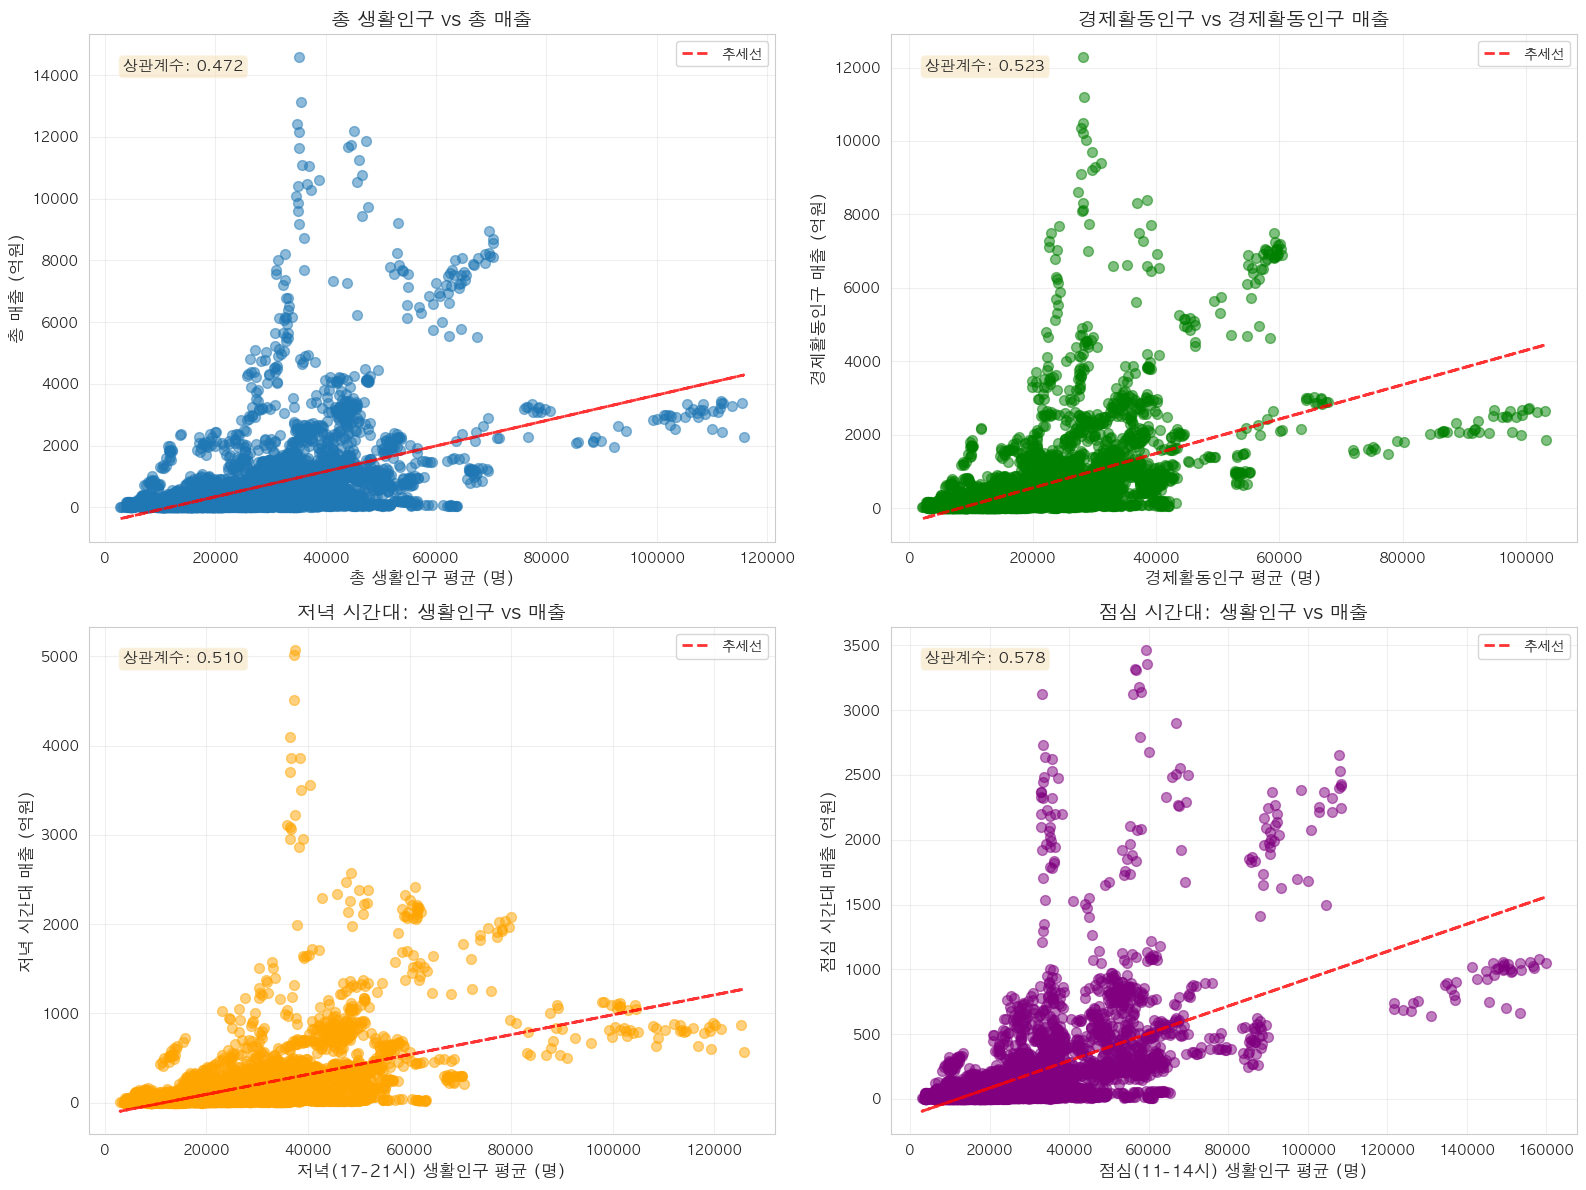


📊 시간대별 상관계수 요약:
새벽(00-06)      :  0.131
아침(06-11)      :  0.339
점심(11-14)      :  0.578
오후(14-17)      :  0.497
저녁(17-21)      :  0.510
밤(21-24)       :  0.392


In [12]:
# 주요 변수 간 산점도
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. 총 생활인구 vs 총 매출
ax1 = axes[0, 0]
ax1.scatter(merged_df['총생활인구_평균'], merged_df['THSMON_SELNG_AMT'] / 1e8,
            alpha=0.5, s=50)
ax1.set_xlabel('총 생활인구 평균 (명)', fontsize=12)
ax1.set_ylabel('총 매출 (억원)', fontsize=12)
ax1.set_title('총 생활인구 vs 총 매출', fontsize=14, fontweight='bold')
# 추세선
z = np.polyfit(merged_df['총생활인구_평균'], merged_df['THSMON_SELNG_AMT'] / 1e8, 1)
p = np.poly1d(z)
ax1.plot(merged_df['총생활인구_평균'], p(merged_df['총생활인구_평균']),
         "r--", alpha=0.8, linewidth=2, label='추세선')
corr1 = merged_df['총생활인구_평균'].corr(merged_df['THSMON_SELNG_AMT'])
ax1.text(0.05, 0.95, f'상관계수: {corr1:.3f}', transform=ax1.transAxes,
         fontsize=11, va='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. 경제활동인구 vs 경제활동인구 매출
ax2 = axes[0, 1]
ax2.scatter(merged_df['경제활동인구_평균'], merged_df['ECNMY_ACTIVE_POP_SELNG_AMT'] / 1e8,
            alpha=0.5, s=50, color='green')
ax2.set_xlabel('경제활동인구 평균 (명)', fontsize=12)
ax2.set_ylabel('경제활동인구 매출 (억원)', fontsize=12)
ax2.set_title('경제활동인구 vs 경제활동인구 매출', fontsize=14, fontweight='bold')
z = np.polyfit(merged_df['경제활동인구_평균'], merged_df['ECNMY_ACTIVE_POP_SELNG_AMT'] / 1e8, 1)
p = np.poly1d(z)
ax2.plot(merged_df['경제활동인구_평균'], p(merged_df['경제활동인구_평균']),
         "r--", alpha=0.8, linewidth=2, label='추세선')
corr2 = merged_df['경제활동인구_평균'].corr(merged_df['ECNMY_ACTIVE_POP_SELNG_AMT'])
ax2.text(0.05, 0.95, f'상관계수: {corr2:.3f}', transform=ax2.transAxes,
         fontsize=11, va='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. 저녁 시간대 인구 vs 저녁 시간대 매출
ax3 = axes[1, 0]
ax3.scatter(merged_df['생활인구_TMZON_17_21_평균'], merged_df['TMZON_17_21_SELNG_AMT'] / 1e8,
            alpha=0.5, s=50, color='orange')
ax3.set_xlabel('저녁(17-21시) 생활인구 평균 (명)', fontsize=12)
ax3.set_ylabel('저녁 시간대 매출 (억원)', fontsize=12)
ax3.set_title('저녁 시간대: 생활인구 vs 매출', fontsize=14, fontweight='bold')
z = np.polyfit(merged_df['생활인구_TMZON_17_21_평균'], merged_df['TMZON_17_21_SELNG_AMT'] / 1e8, 1)
p = np.poly1d(z)
ax3.plot(merged_df['생활인구_TMZON_17_21_평균'], p(merged_df['생활인구_TMZON_17_21_평균']),
         "r--", alpha=0.8, linewidth=2, label='추세선')
corr3 = merged_df['생활인구_TMZON_17_21_평균'].corr(merged_df['TMZON_17_21_SELNG_AMT'])
ax3.text(0.05, 0.95, f'상관계수: {corr3:.3f}', transform=ax3.transAxes,
         fontsize=11, va='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. 점심 시간대 인구 vs 점심 시간대 매출
ax4 = axes[1, 1]
ax4.scatter(merged_df['생활인구_TMZON_11_14_평균'], merged_df['TMZON_11_14_SELNG_AMT'] / 1e8,
            alpha=0.5, s=50, color='purple')
ax4.set_xlabel('점심(11-14시) 생활인구 평균 (명)', fontsize=12)
ax4.set_ylabel('점심 시간대 매출 (억원)', fontsize=12)
ax4.set_title('점심 시간대: 생활인구 vs 매출', fontsize=14, fontweight='bold')
z = np.polyfit(merged_df['생활인구_TMZON_11_14_평균'], merged_df['TMZON_11_14_SELNG_AMT'] / 1e8, 1)
p = np.poly1d(z)
ax4.plot(merged_df['생활인구_TMZON_11_14_평균'], p(merged_df['생활인구_TMZON_11_14_평균']),
         "r--", alpha=0.8, linewidth=2, label='추세선')
corr4 = merged_df['생활인구_TMZON_11_14_평균'].corr(merged_df['TMZON_11_14_SELNG_AMT'])
ax4.text(0.05, 0.95, f'상관계수: {corr4:.3f}', transform=ax4.transAxes,
         fontsize=11, va='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 시간대별 상관계수 요약:")
print("="*60)
timeslot_corr = {
    '새벽(00-06)': merged_df['생활인구_TMZON_00_06_평균'].corr(merged_df['TMZON_00_06_SELNG_AMT']),
    '아침(06-11)': merged_df['생활인구_TMZON_06_11_평균'].corr(merged_df['TMZON_06_11_SELNG_AMT']),
    '점심(11-14)': merged_df['생활인구_TMZON_11_14_평균'].corr(merged_df['TMZON_11_14_SELNG_AMT']),
    '오후(14-17)': merged_df['생활인구_TMZON_14_17_평균'].corr(merged_df['TMZON_14_17_SELNG_AMT']),
    '저녁(17-21)': merged_df['생활인구_TMZON_17_21_평균'].corr(merged_df['TMZON_17_21_SELNG_AMT']),
    '밤(21-24)': merged_df['생활인구_TMZON_21_24_평균'].corr(merged_df['TMZON_21_24_SELNG_AMT'])
}

for timeslot, corr in timeslot_corr.items():
    print(f"{timeslot:15s}: {corr:6.3f}")

## 8. 1인당 소비액 분석 (소비 효율성)

💵 1인당 소비액 계산 중...
✅ 계산 완료

📊 1인당 소비액 통계:
            1인당_총매출  경제활동인구_1인당_매출
count  7.816000e+03   7.816000e+03
mean   1.836753e+06   2.135374e+06
std    2.897203e+06   3.082523e+06
min    1.381244e+02   2.023183e+02
25%    4.472907e+05   5.826794e+05
50%    9.577429e+05   1.197457e+06
75%    2.109765e+06   2.531947e+06
max    4.136810e+07   4.355352e+07

🏆 1인당 총매출 상위 10개 행정동:
     ADSTRD_NM  QUARTER  총생활인구_평균  THSMON_SELNG_AMT_억  1인당_총매출_만원
5695     노량진1동        4     35227             14572.7      4136.8
5691     노량진1동        4     35446             13130.8      3704.4
5699     노량진1동        4     34787             12407.2      3566.6
5696     노량진1동        1     35228             12170.0      3454.6
5692     노량진1동        1     35121             11653.2      3318.0
5684     노량진1동        1     35656             11077.9      3106.9
5689     노량진1동        2     36893             11052.8      2995.9
5693     노량진1동        2     35060             10415.3      2970.7
5694     노량진1동        3    

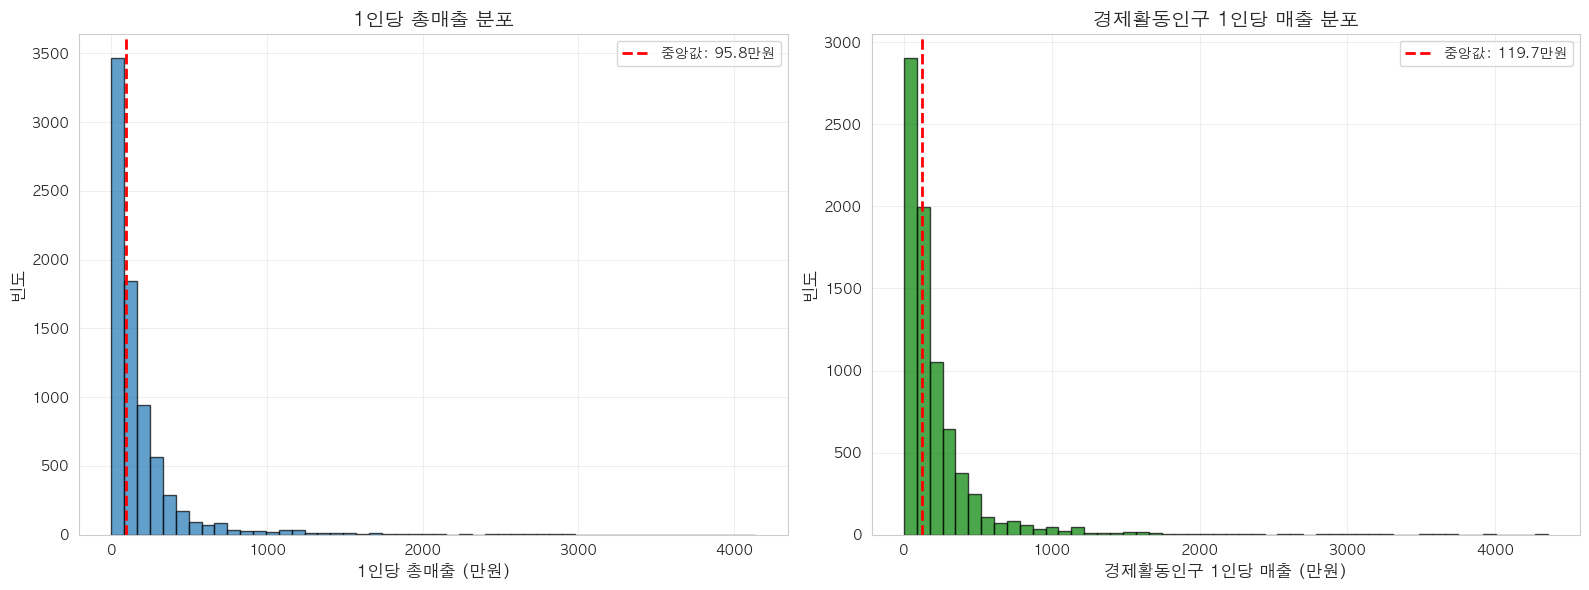

In [13]:
print("💵 1인당 소비액 계산 중...")

# 1인당 총 매출
merged_df['1인당_총매출'] = (merged_df['THSMON_SELNG_AMT'] / merged_df['총생활인구_평균']).replace([np.inf, -np.inf], np.nan)

# 경제활동인구 1인당 매출
merged_df['경제활동인구_1인당_매출'] = (merged_df['ECNMY_ACTIVE_POP_SELNG_AMT'] / merged_df['경제활동인구_평균']).replace([np.inf, -np.inf], np.nan)

# 결측치 제거
merged_df = merged_df.dropna(subset=['1인당_총매출', '경제활동인구_1인당_매출'])

print(f"✅ 계산 완료")
print(f"\n📊 1인당 소비액 통계:")
print(merged_df[['1인당_총매출', '경제활동인구_1인당_매출']].describe())

# 상위 10개 행정동
print(f"\n🏆 1인당 총매출 상위 10개 행정동:")
top10_per_capita = merged_df.nlargest(10, '1인당_총매출')[['ADSTRD_NM', 'QUARTER', '총생활인구_평균', 'THSMON_SELNG_AMT', '1인당_총매출']]
top10_per_capita['THSMON_SELNG_AMT_억'] = (top10_per_capita['THSMON_SELNG_AMT'] / 1e8).round(1)
top10_per_capita['1인당_총매출_만원'] = (top10_per_capita['1인당_총매출'] / 1e4).round(1)
print(top10_per_capita[['ADSTRD_NM', 'QUARTER', '총생활인구_평균', 'THSMON_SELNG_AMT_억', '1인당_총매출_만원']])

# 시각화
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1인당 총매출 분포
ax1 = axes[0]
ax1.hist(merged_df['1인당_총매출'] / 1e4, bins=50, edgecolor='black', alpha=0.7)
ax1.set_xlabel('1인당 총매출 (만원)', fontsize=12)
ax1.set_ylabel('빈도', fontsize=12)
ax1.set_title('1인당 총매출 분포', fontsize=14, fontweight='bold')
ax1.axvline(merged_df['1인당_총매출'].median() / 1e4, color='red', linestyle='--',
            linewidth=2, label=f'중앙값: {merged_df["1인당_총매출"].median()/1e4:.1f}만원')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 경제활동인구 1인당 매출 분포
ax2 = axes[1]
ax2.hist(merged_df['경제활동인구_1인당_매출'] / 1e4, bins=50, edgecolor='black', alpha=0.7, color='green')
ax2.set_xlabel('경제활동인구 1인당 매출 (만원)', fontsize=12)
ax2.set_ylabel('빈도', fontsize=12)
ax2.set_title('경제활동인구 1인당 매출 분포', fontsize=14, fontweight='bold')
ax2.axvline(merged_df['경제활동인구_1인당_매출'].median() / 1e4, color='red', linestyle='--',
            linewidth=2, label=f'중앙값: {merged_df["경제활동인구_1인당_매출"].median()/1e4:.1f}만원')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 9. 경제 활력 지수 계산

### 방법론:
1. **매출 역동성 (35점)**: 분기별 매출 변화율, 안정성, 주중/주말 균형
2. **소비 효율성 (25점)**: 1인당 소비액
3. **시간 회복력 (25점)**: 야간 매출 비율, 시간대 분산도
4. **경제 다양성 (15점)**: 연령대별 매출 균형도, 성별 균형도

**총점: 100점 만점**

In [30]:
print("🎯 경제 활력 지수 계산 중...")

# 필요한 지표들 계산
vitality_df = merged_df.copy()

# 1. 매출 역동성 (35점)
# 1-1. 분기별 성장률 (분기 데이터이므로 전년 동기 대비로 계산 불가 - 동일 연도 내 추세만 가능)
# 여기서는 분기별 편차를 안정성 지표로 사용
quarterly_sales_std = vitality_df.groupby('ADSTRD_CD')['THSMON_SELNG_AMT'].transform('std')
quarterly_sales_mean = vitality_df.groupby('ADSTRD_CD')['THSMON_SELNG_AMT'].transform('mean')
vitality_df['매출_안정성'] = 1 - (quarterly_sales_std / quarterly_sales_mean).clip(0, 1)  # 낮을수록 안정

# 1-2. 주중/주말 균형도
vitality_df['주말_비율'] = vitality_df['WKEND_SELNG_AMT'] / vitality_df['THSMON_SELNG_AMT']
vitality_df['주말_균형도'] = 1 - abs(vitality_df['주말_비율'] - 0.3)  # 이상적 주말 비율 30%로 가정

# 매출 역동성 점수 (35점)
vitality_df['매출역동성_점수'] = (
    vitality_df['매출_안정성'] * 20 +  # 안정성 20점
    vitality_df['주말_균형도'] * 15     # 균형도 15점
).clip(0, 30.6)

# 2. 소비 효율성 (25점)
# 1인당 소비액을 정규화 (상위 10%를 만점으로)
per_capita_90th = vitality_df['1인당_총매출'].quantile(0.90)
vitality_df['소비효율성_점수'] = (vitality_df['1인당_총매출'] / per_capita_90th * 25).clip(0, 11.9)

# 3. 시간 회복력 (25점)
# 3-1. 야간 매출 비율 (21시~06시)
vitality_df['야간매출'] = vitality_df['TMZON_21_24_SELNG_AMT'] + vitality_df['TMZON_00_06_SELNG_AMT']
vitality_df['야간매출_비율'] = vitality_df['야간매출'] / vitality_df['THSMON_SELNG_AMT']

# 3-2. 시간대 분산도 (균등하게 분산될수록 높은 점수)
time_cols = ['TMZON_00_06_SELNG_AMT', 'TMZON_06_11_SELNG_AMT', 'TMZON_11_14_SELNG_AMT',
             'TMZON_14_17_SELNG_AMT', 'TMZON_17_21_SELNG_AMT', 'TMZON_21_24_SELNG_AMT']
vitality_df['시간대_분산'] = vitality_df[time_cols].std(axis=1) / vitality_df[time_cols].mean(axis=1)
vitality_df['시간대_균등도'] = 1 - vitality_df['시간대_분산'].clip(0, 1)

# 시간 회복력 점수 (25점)
vitality_df['시간회복력_점수'] = (
    (vitality_df['야간매출_비율'] * 100) * 0.15 +  # 야간 비율 15점
    vitality_df['시간대_균등도'] * 10               # 균등도 10점
).clip(0, 25.1)

# 4. 경제 다양성 (15점)
# 4-1. 연령대별 균등도
age_cols = ['AGRDE_20_SELNG_AMT', 'AGRDE_30_SELNG_AMT', 'AGRDE_40_SELNG_AMT',
            'AGRDE_50_SELNG_AMT', 'AGRDE_60_ABOVE_SELNG_AMT']
vitality_df['연령_분산'] = vitality_df[age_cols].std(axis=1) / vitality_df[age_cols].mean(axis=1)
vitality_df['연령_균등도'] = 1 - vitality_df['연령_분산'].clip(0, 1)

# 4-2. 성별 균형도
vitality_df['여성매출_비율'] = vitality_df['FML_SELNG_AMT'] / (vitality_df['ML_SELNG_AMT'] + vitality_df['FML_SELNG_AMT'])
vitality_df['성별_균형도'] = 1 - abs(vitality_df['여성매출_비율'] - 0.5) * 2  # 50%가 이상적

# 경제 다양성 점수 (15점)
vitality_df['경제다양성_점수'] = (
    vitality_df['연령_균등도'] * 8 +
    vitality_df['성별_균형도'] * 7
).clip(0, 32.4)

# 최종 활력 지수 (100점 만점)
vitality_df['경제활력지수'] = (
    vitality_df['매출역동성_점수'] +
    vitality_df['소비효율성_점수'] +
    vitality_df['시간회복력_점수'] +
    vitality_df['경제다양성_점수']
)

# 등급 부여
def assign_grade(score):
    if score >= 80:
        return '🔴 핫존 (80점 이상)'
    elif score >= 60:
        return '🟡 안정 (60-80점)'
    elif score >= 40:
        return '🟢 주의 (40-60점)'
    else:
        return '🔵 콜드존 (40점 미만)'

vitality_df['활력등급'] = vitality_df['경제활력지수'].apply(assign_grade)

print("✅ 경제 활력 지수 계산 완료!")
print(f"\n📊 활력 지수 분포:")
print(vitality_df['경제활력지수'].describe())
print(f"\n🏆 등급별 분포:")
print(vitality_df['활력등급'].value_counts().sort_index())

🎯 경제 활력 지수 계산 중...
✅ 경제 활력 지수 계산 완료!

📊 활력 지수 분포:
count    7816.000000
mean       51.846932
std         6.280550
min        20.594000
25%        48.197524
50%        52.308266
75%        56.531125
max        66.600798
Name: 경제활력지수, dtype: float64

🏆 등급별 분포:
활력등급
🔵 콜드존 (40점 미만)     347
🟡 안정 (60-80점)      536
🟢 주의 (40-60점)     6933
Name: count, dtype: int64


### 9.1 핫존 / 콜드존 분석

🔥 활력 지수 상위 20개 행정동 (핫존)
ADSTRD_NM  QUARTER  경제활력지수          활력등급  매출역동성_점수  소비효율성_점수  시간회복력_점수  경제다양성_점수
     갈현1동        3    66.6 🟡 안정 (60-80점)      30.6 11.900000  9.759802 14.340996
     갈현1동        4    66.5 🟡 안정 (60-80점)      30.6 11.900000  9.747239 14.247727
     갈현1동        1    66.4 🟡 안정 (60-80점)      30.6 11.900000  9.968367 13.903158
     갈현1동        3    66.4 🟡 안정 (60-80점)      30.6 11.900000  9.858858 14.004039
     갈현1동        2    66.2 🟡 안정 (60-80점)      30.6 11.900000  9.854259 13.886193
     갈현1동        2    66.1 🟡 안정 (60-80점)      30.6 11.900000  9.354555 14.275452
     갈현1동        1    66.0 🟡 안정 (60-80점)      30.6 11.900000  9.405838 14.081812
     갈현1동        4    65.9 🟡 안정 (60-80점)      30.6 11.900000  9.327900 14.038527
     갈현1동        4    65.6 🟡 안정 (60-80점)      30.6 11.900000  9.436984 13.620822
     갈현1동        3    65.5 🟡 안정 (60-80점)      30.6 11.900000  9.445642 13.516145
     갈현1동        2    65.3 🟡 안정 (60-80점)      30.6 11.900000  9.198100 13.556652
    

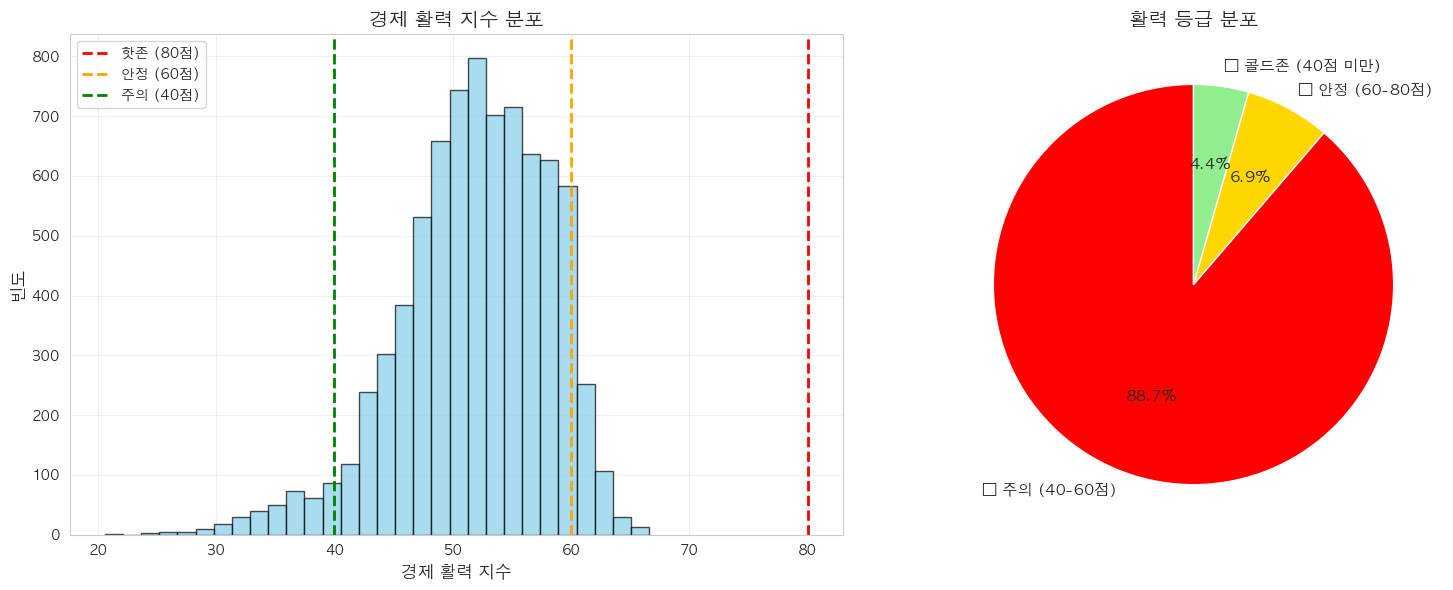

In [31]:
# 상위 20개 핫존
print("🔥 활력 지수 상위 20개 행정동 (핫존)")
print("="*100)
top20 = vitality_df.nlargest(20, '경제활력지수')[
    ['ADSTRD_NM', 'QUARTER', '경제활력지수', '활력등급', '매출역동성_점수',
     '소비효율성_점수', '시간회복력_점수', '경제다양성_점수', 'THSMON_SELNG_AMT', '1인당_총매출']
].copy()
top20['총매출_억'] = (top20['THSMON_SELNG_AMT'] / 1e8).round(1)
top20['1인당_만원'] = (top20['1인당_총매출'] / 1e4).round(1)
top20['경제활력지수'] = top20['경제활력지수'].round(1)

print(top20[['ADSTRD_NM', 'QUARTER', '경제활력지수', '활력등급',
             '매출역동성_점수', '소비효율성_점수', '시간회복력_점수', '경제다양성_점수']].to_string(index=False))

# 하위 20개 콜드존
print("\n\n❄️  활력 지수 하위 20개 행정동 (콜드존)")
print("="*100)
bottom20 = vitality_df.nsmallest(20, '경제활력지수')[
    ['ADSTRD_NM', 'QUARTER', '경제활력지수', '활력등급', '매출역동성_점수',
     '소비효율성_점수', '시간회복력_점수', '경제다양성_점수', 'THSMON_SELNG_AMT', '1인당_총매출']
].copy()
bottom20['총매출_억'] = (bottom20['THSMON_SELNG_AMT'] / 1e8).round(1)
bottom20['1인당_만원'] = (bottom20['1인당_총매출'] / 1e4).round(1)
bottom20['경제활력지수'] = bottom20['경제활력지수'].round(1)

print(bottom20[['ADSTRD_NM', 'QUARTER', '경제활력지수', '활력등급',
                '매출역동성_점수', '소비효율성_점수', '시간회복력_점수', '경제다양성_점수']].to_string(index=False))

# 활력 지수 분포 시각화
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 히스토그램
ax1 = axes[0]
ax1.hist(vitality_df['경제활력지수'], bins=30, edgecolor='black', alpha=0.7, color='skyblue')
ax1.axvline(80, color='red', linestyle='--', linewidth=2, label='핫존 (80점)')
ax1.axvline(60, color='orange', linestyle='--', linewidth=2, label='안정 (60점)')
ax1.axvline(40, color='green', linestyle='--', linewidth=2, label='주의 (40점)')
ax1.set_xlabel('경제 활력 지수', fontsize=12)
ax1.set_ylabel('빈도', fontsize=12)
ax1.set_title('경제 활력 지수 분포', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 등급별 파이 차트
ax2 = axes[1]
grade_counts = vitality_df['활력등급'].value_counts()
colors = ['red', 'gold', 'lightgreen', 'lightblue']
ax2.pie(grade_counts.values, labels=grade_counts.index, autopct='%1.1f%%',
        startangle=90, colors=colors, textprops={'fontsize': 11})
ax2.set_title('활력 등급 분포', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

### 9.2 활력 지수 구성 요소별 분석

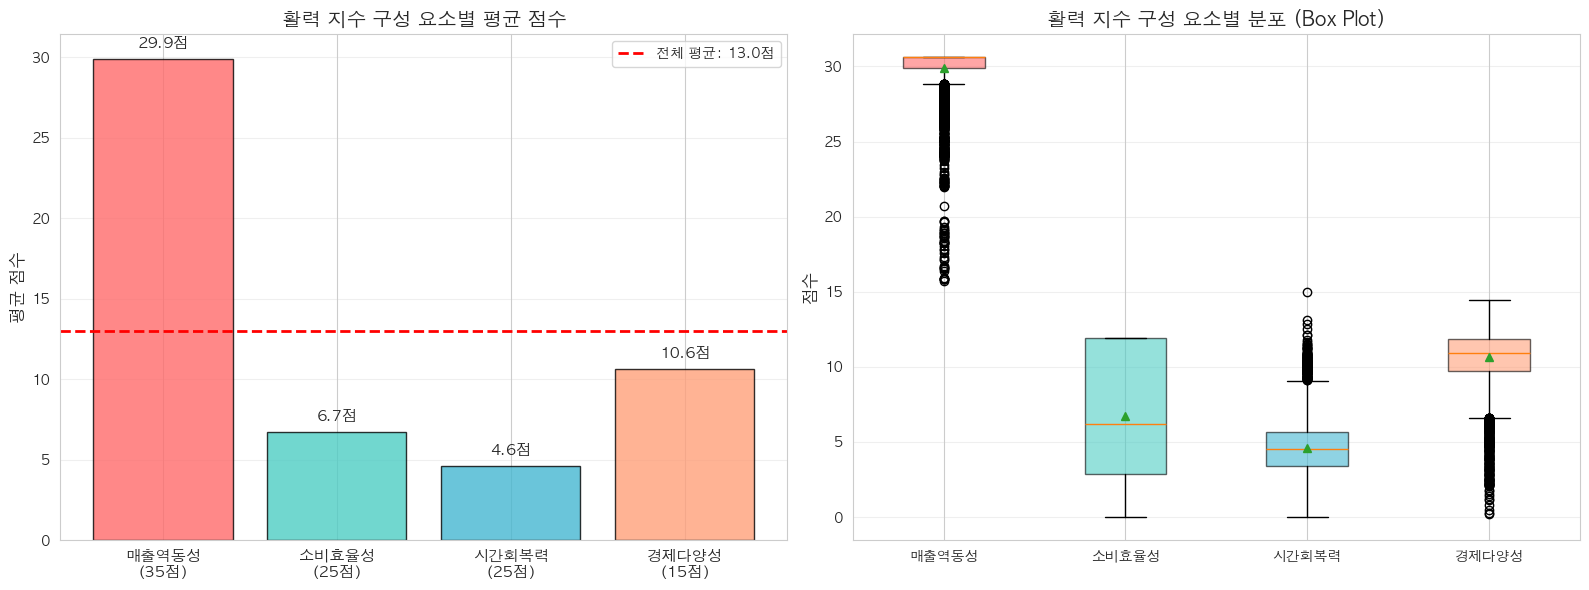


📊 구성 요소별 통계:
          매출역동성_점수     소비효율성_점수     시간회복력_점수     경제다양성_점수
count  7816.000000  7816.000000  7816.000000  7816.000000
mean     29.926825     6.710285     4.583473    10.626348
std       1.504812     4.215369     1.888098     1.862054
min      15.697158     0.000889     0.000000     0.221862
25%      29.890175     2.878884     3.401631     9.756270
50%      30.600000     6.164291     4.527029    10.918520
75%      30.600000    11.900000     5.677482    11.851062
max      30.600000    11.900000    15.000000    14.435167


In [32]:
# 4가지 요소별 평균 점수
component_scores = vitality_df[['매출역동성_점수', '소비효율성_점수', '시간회복력_점수', '경제다양성_점수']].mean()

# 막대 그래프
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 평균 점수 막대 그래프
ax1 = axes[0]
colors_bar = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A']
bars = ax1.bar(range(4), component_scores.values, color=colors_bar, edgecolor='black', alpha=0.8)
ax1.set_xticks(range(4))
ax1.set_xticklabels(['매출역동성\n(35점)', '소비효율성\n(25점)', '시간회복력\n(25점)', '경제다양성\n(15점)'], fontsize=11)
ax1.set_ylabel('평균 점수', fontsize=12)
ax1.set_title('활력 지수 구성 요소별 평균 점수', fontsize=14, fontweight='bold')
ax1.axhline(y=component_scores.mean(), color='red', linestyle='--', linewidth=2, label=f'전체 평균: {component_scores.mean():.1f}점')

# 막대 위에 값 표시
for i, (bar, val) in enumerate(zip(bars, component_scores.values)):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
             f'{val:.1f}점', ha='center', va='bottom', fontsize=11, fontweight='bold')

ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')

# 박스플롯
ax2 = axes[1]
component_data = [
    vitality_df['매출역동성_점수'],
    vitality_df['소비효율성_점수'],
    vitality_df['시간회복력_점수'],
    vitality_df['경제다양성_점수']
]
bp = ax2.boxplot(component_data, labels=['매출역동성', '소비효율성', '시간회복력', '경제다양성'],
                 patch_artist=True, showmeans=True)

for patch, color in zip(bp['boxes'], colors_bar):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)

ax2.set_ylabel('점수', fontsize=12)
ax2.set_title('활력 지수 구성 요소별 분포 (Box Plot)', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n📊 구성 요소별 통계:")
print("="*80)
print(vitality_df[['매출역동성_점수', '소비효율성_점수', '시간회복력_점수', '경제다양성_점수']].describe())

## 10. AI 매출 예측 모델 구축

### 10.1 데이터 준비 및 특성 선택

In [33]:
print("🤖 AI 매출 예측 모델 구축 중...")

# 특성(Feature) 선택
feature_cols = [
    '총생활인구_평균',
    '경제활동인구_평균',
    '남성_20_60대_평균',
    '여성_20_60대_평균',
    '생활인구_TMZON_00_06_평균',
    '생활인구_TMZON_06_11_평균',
    '생활인구_TMZON_11_14_평균',
    '생활인구_TMZON_14_17_평균',
    '생활인구_TMZON_17_21_평균',
    '생활인구_TMZON_21_24_평균',
    'QUARTER'  # 분기도 특성으로 추가
]

# 타겟(Target) 변수
target_col = 'THSMON_SELNG_AMT'

# 결측치 제거
ml_df = vitality_df[feature_cols + [target_col, 'ADSTRD_NM']].dropna()

print(f"✅ 데이터 준비 완료")
print(f"   학습 데이터: {len(ml_df):,}개 행")
print(f"   특성 개수: {len(feature_cols)}개")
print(f"\n특성 목록:")
for i, col in enumerate(feature_cols, 1):
    print(f"  {i:2d}. {col}")

# Train/Test 분할 (80:20)
X = ml_df[feature_cols]
y = ml_df[target_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\n✅ 데이터 분할 완료")
print(f"   학습 데이터: {len(X_train):,}개")
print(f"   테스트 데이터: {len(X_test):,}개")

🤖 AI 매출 예측 모델 구축 중...
✅ 데이터 준비 완료
   학습 데이터: 7,816개 행
   특성 개수: 11개

특성 목록:
   1. 총생활인구_평균
   2. 경제활동인구_평균
   3. 남성_20_60대_평균
   4. 여성_20_60대_평균
   5. 생활인구_TMZON_00_06_평균
   6. 생활인구_TMZON_06_11_평균
   7. 생활인구_TMZON_11_14_평균
   8. 생활인구_TMZON_14_17_평균
   9. 생활인구_TMZON_17_21_평균
  10. 생활인구_TMZON_21_24_평균
  11. QUARTER

✅ 데이터 분할 완료
   학습 데이터: 6,252개
   테스트 데이터: 1,564개


### 10.2 모델 학습 및 비교

In [34]:
print("🔧 모델 학습 중...")
print("="*80)

# 3가지 모델 학습
models = {
    '선형 회귀 (Linear Regression)': LinearRegression(),
    '랜덤 포레스트 (Random Forest)': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    '그래디언트 부스팅 (Gradient Boosting)': GradientBoostingRegressor(n_estimators=100, random_state=42)
}

results = {}

for name, model in models.items():
    print(f"\n학습 중: {name}")
    model.fit(X_train, y_train)

    # 예측
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    # 평가
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)
    test_mae = mean_absolute_error(y_test, y_pred_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

    results[name] = {
        'model': model,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'test_mae': test_mae,
        'test_rmse': test_rmse,
        'y_pred_test': y_pred_test
    }

    print(f"  ✅ 학습 완료")
    print(f"     학습 R²: {train_r2:.4f}")
    print(f"     테스트 R²: {test_r2:.4f}")
    print(f"     MAE: {test_mae/1e8:.2f}억원")
    print(f"     RMSE: {test_rmse/1e8:.2f}억원")

print("\n" + "="*80)
print("✅ 모델 학습 완료!")

# 결과 비교 테이블
results_df = pd.DataFrame({
    '모델': list(results.keys()),
    '학습_R2': [r['train_r2'] for r in results.values()],
    '테스트_R2': [r['test_r2'] for r in results.values()],
    'MAE_억원': [r['test_mae']/1e8 for r in results.values()],
    'RMSE_억원': [r['test_rmse']/1e8 for r in results.values()]
})

print("\n📊 모델 성능 비교:")
print(results_df.to_string(index=False))

🔧 모델 학습 중...

학습 중: 선형 회귀 (Linear Regression)
  ✅ 학습 완료
     학습 R²: 0.4239
     테스트 R²: 0.4083
     MAE: 381.39억원
     RMSE: 904.69억원

학습 중: 랜덤 포레스트 (Random Forest)
  ✅ 학습 완료
     학습 R²: 0.9748
     테스트 R²: 0.8262
     MAE: 170.08억원
     RMSE: 490.31억원

학습 중: 그래디언트 부스팅 (Gradient Boosting)
  ✅ 학습 완료
     학습 R²: 0.8289
     테스트 R²: 0.6894
     MAE: 275.33억원
     RMSE: 655.50억원

✅ 모델 학습 완료!

📊 모델 성능 비교:
                           모델    학습_R2   테스트_R2     MAE_억원    RMSE_억원
    선형 회귀 (Linear Regression) 0.423944 0.408300 381.389972 904.694200
      랜덤 포레스트 (Random Forest) 0.974761 0.826201 170.077407 490.313751
그래디언트 부스팅 (Gradient Boosting) 0.828865 0.689367 275.327449 655.502762


### 10.3 모델 예측 결과 시각화

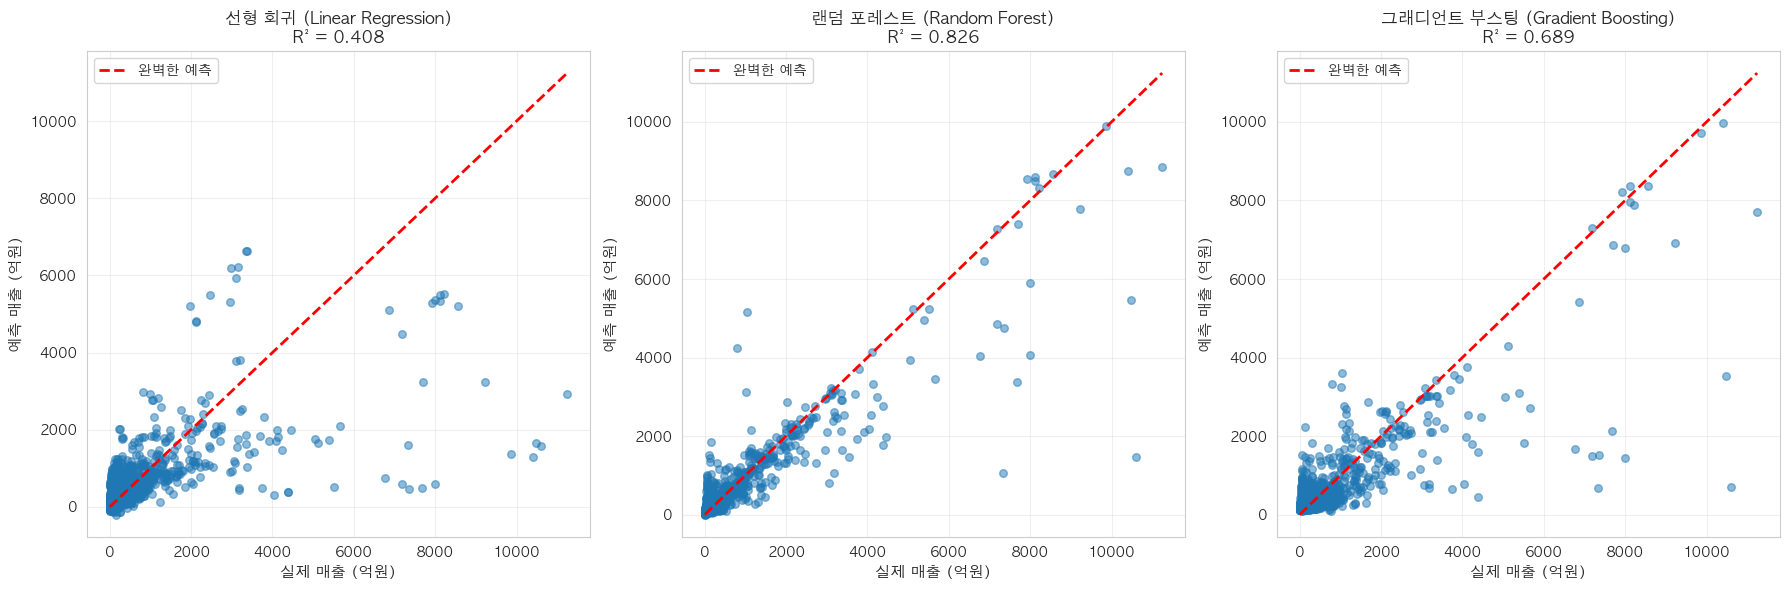

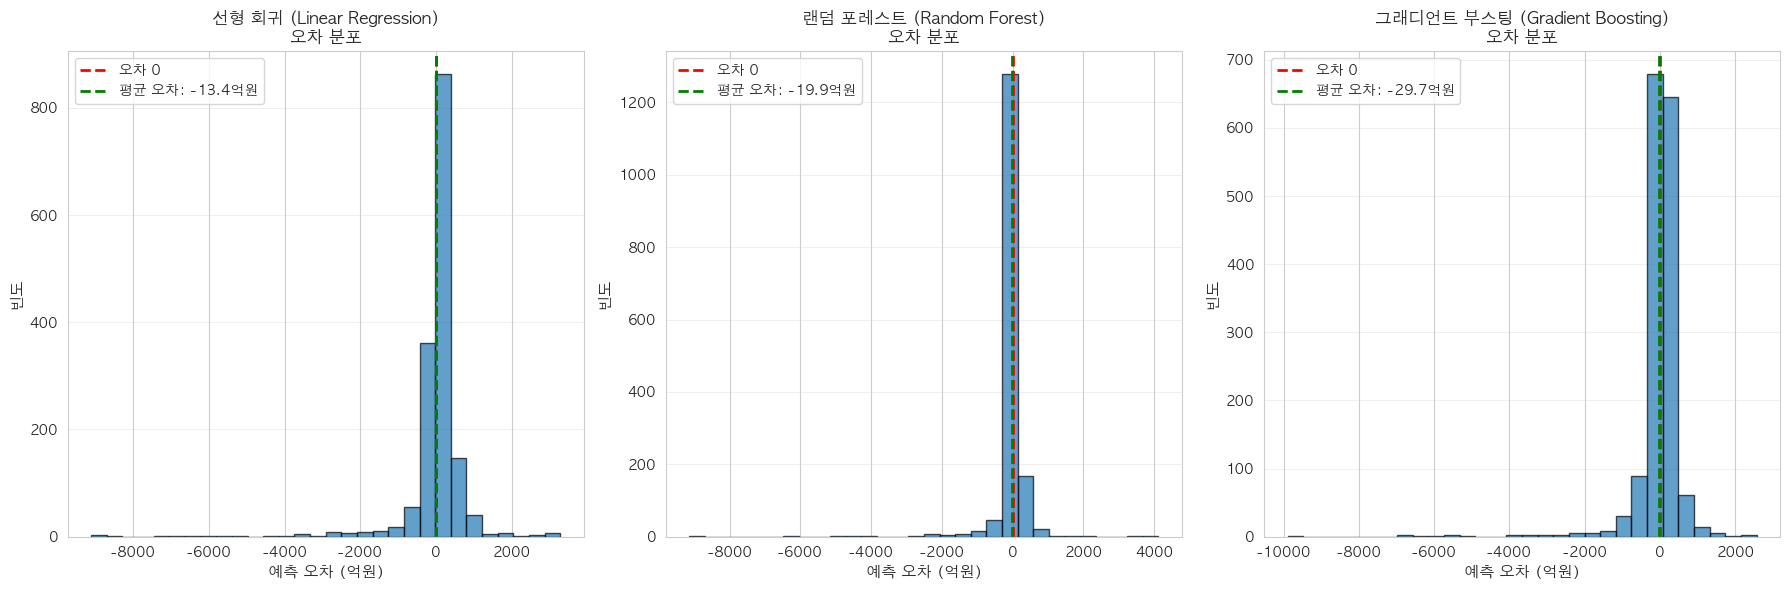

In [35]:
# 모델별 예측 결과 시각화
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for idx, (name, result) in enumerate(results.items()):
    ax = axes[idx]

    # 실제값 vs 예측값 산점도
    ax.scatter(y_test / 1e8, result['y_pred_test'] / 1e8, alpha=0.5, s=30)

    # 완벽한 예측선 (y=x)
    max_val = max(y_test.max(), result['y_pred_test'].max()) / 1e8
    ax.plot([0, max_val], [0, max_val], 'r--', linewidth=2, label='완벽한 예측')

    ax.set_xlabel('실제 매출 (억원)', fontsize=11)
    ax.set_ylabel('예측 매출 (억원)', fontsize=11)
    ax.set_title(f'{name}\nR² = {result["test_r2"]:.3f}', fontsize=12, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 오차 분포 시각화
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for idx, (name, result) in enumerate(results.items()):
    ax = axes[idx]

    # 예측 오차 계산
    errors = (result['y_pred_test'] - y_test) / 1e8

    # 히스토그램
    ax.hist(errors, bins=30, edgecolor='black', alpha=0.7)
    ax.axvline(0, color='red', linestyle='--', linewidth=2, label='오차 0')
    ax.axvline(errors.mean(), color='green', linestyle='--', linewidth=2,
               label=f'평균 오차: {errors.mean():.1f}억원')

    ax.set_xlabel('예측 오차 (억원)', fontsize=11)
    ax.set_ylabel('빈도', fontsize=11)
    ax.set_title(f'{name}\n오차 분포', fontsize=12, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

### 10.4 특성 중요도 분석 (Random Forest)

🔍 특성 중요도 (Random Forest):
                 특성      중요도
       남성_20_60대_평균 0.289807
생활인구_TMZON_14_17_평균 0.212586
생활인구_TMZON_00_06_평균 0.129414
생활인구_TMZON_21_24_평균 0.068573
       여성_20_60대_평균 0.068487
생활인구_TMZON_17_21_평균 0.067237
생활인구_TMZON_11_14_평균 0.055476
생활인구_TMZON_06_11_평균 0.044895
          경제활동인구_평균 0.041669
           총생활인구_평균 0.019002
            QUARTER 0.002854


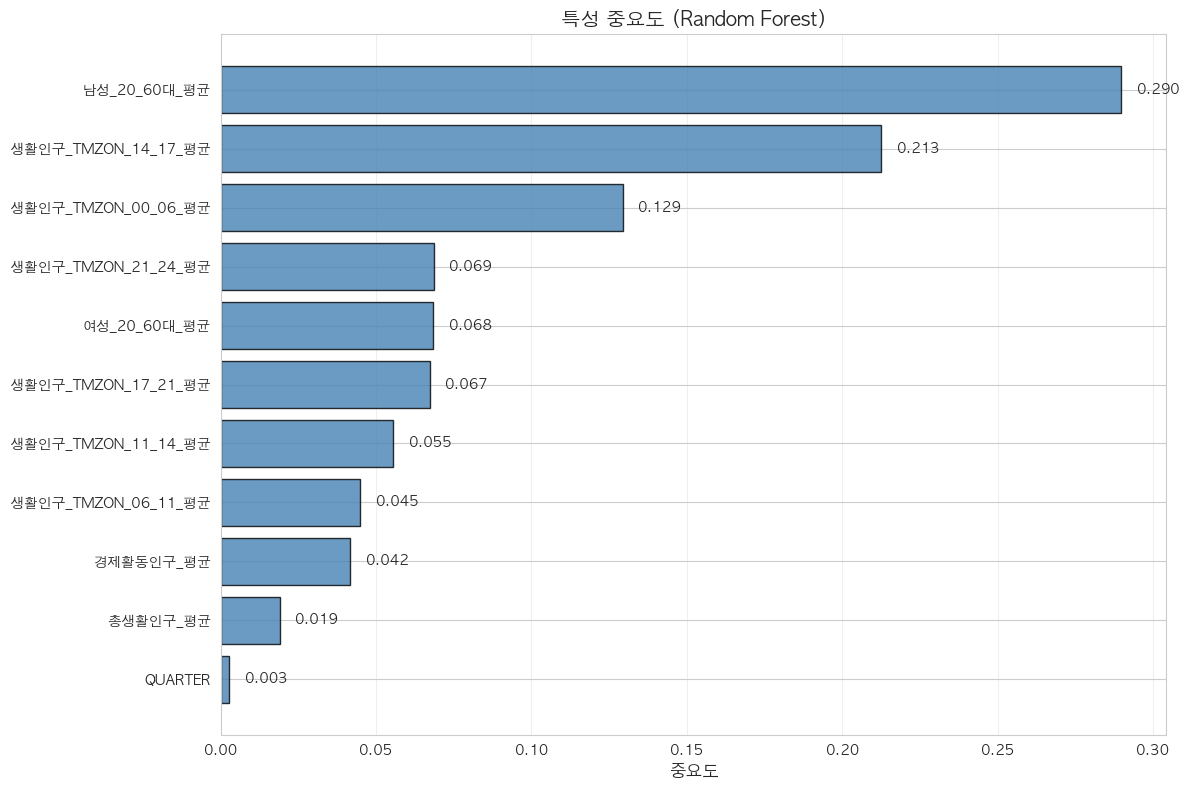


💡 핵심 인사이트:
   매출 예측에 가장 중요한 3가지 요소:
   1. 남성_20_60대_평균 (중요도: 0.290)
   2. 생활인구_TMZON_14_17_평균 (중요도: 0.213)
   3. 생활인구_TMZON_00_06_평균 (중요도: 0.129)


In [36]:
# Random Forest 모델의 특성 중요도
rf_model = results['랜덤 포레스트 (Random Forest)']['model']
feature_importance = pd.DataFrame({
    '특성': feature_cols,
    '중요도': rf_model.feature_importances_
}).sort_values('중요도', ascending=False)

print("🔍 특성 중요도 (Random Forest):")
print("="*60)
print(feature_importance.to_string(index=False))

# 시각화
fig, ax = plt.subplots(figsize=(12, 8))
bars = ax.barh(range(len(feature_importance)), feature_importance['중요도'],
               color='steelblue', edgecolor='black', alpha=0.8)
ax.set_yticks(range(len(feature_importance)))
ax.set_yticklabels(feature_importance['특성'])
ax.set_xlabel('중요도', fontsize=12)
ax.set_title('특성 중요도 (Random Forest)', fontsize=14, fontweight='bold')
ax.invert_yaxis()
ax.grid(True, alpha=0.3, axis='x')

# 막대 옆에 값 표시
for i, (bar, val) in enumerate(zip(bars, feature_importance['중요도'])):
    ax.text(val + 0.005, bar.get_y() + bar.get_height()/2,
            f'{val:.3f}', va='center', fontsize=10)

plt.tight_layout()
plt.show()

# 핵심 인사이트
top3_features = feature_importance.head(3)
print(f"\n💡 핵심 인사이트:")
print(f"   매출 예측에 가장 중요한 3가지 요소:")
for i, row in enumerate(top3_features.itertuples(), 1):
    print(f"   {i}. {row.특성} (중요도: {row.중요도:.3f})")

### 10.5 실전 예측 예시

In [37]:
print("🎯 실전 예측 예시")
print("="*80)

# 최고 성능 모델 선택 (R² 기준)
best_model_name = max(results.items(), key=lambda x: x[1]['test_r2'])[0]
best_model = results[best_model_name]['model']

print(f"선택된 모델: {best_model_name}")
print(f"테스트 R²: {results[best_model_name]['test_r2']:.4f}")

# 테스트 데이터에서 랜덤 샘플 10개 추출
sample_indices = np.random.choice(X_test.index, 10, replace=False)
sample_X = X_test.loc[sample_indices]
sample_y_true = y_test.loc[sample_indices]
sample_y_pred = best_model.predict(sample_X)

# 행정동명 가져오기
sample_names = ml_df.loc[sample_indices, 'ADSTRD_NM'].values

# 결과 테이블
prediction_results = pd.DataFrame({
    '행정동': sample_names,
    '실제_매출_억원': (sample_y_true / 1e8).round(1),
    '예측_매출_억원': (sample_y_pred / 1e8).round(1),
    '오차_억원': ((sample_y_pred - sample_y_true) / 1e8).round(1),
    '오차율_%': (((sample_y_pred - sample_y_true) / sample_y_true) * 100).round(1)
})

print(f"\n📊 예측 결과 샘플 (10개):")
print(prediction_results.to_string(index=False))

# What-if 시나리오
print(f"\n\n🔮 What-If 시나리오 분석")
print("="*80)
print(f"\n시나리오: 특정 행정동의 경제활동인구가 20% 증가한다면?")

# 첫 번째 샘플 사용
scenario_X = sample_X.iloc[0:1].copy()
original_name = sample_names[0]
original_sales = sample_y_true.iloc[0]
original_pred = best_model.predict(scenario_X)[0]

print(f"\n대상 행정동: {original_name}")
print(f"현재 경제활동인구: {scenario_X['경제활동인구_평균'].values[0]:,.0f}명")
print(f"현재 실제 매출: {original_sales/1e8:.1f}억원")
print(f"현재 예측 매출: {original_pred/1e8:.1f}억원")

# 경제활동인구 20% 증가 시나리오
scenario_X['경제활동인구_평균'] *= 1.2
scenario_X['남성_20_60대_평균'] *= 1.2
scenario_X['여성_20_60대_평균'] *= 1.2
new_pred = best_model.predict(scenario_X)[0]

print(f"\n변경 후 경제활동인구: {scenario_X['경제활동인구_평균'].values[0]:,.0f}명 (+20%)")
print(f"예상 매출: {new_pred/1e8:.1f}억원")
print(f"매출 증가: {(new_pred - original_pred)/1e8:.1f}억원 ({((new_pred - original_pred)/original_pred * 100):.1f}%)")

🎯 실전 예측 예시
선택된 모델: 랜덤 포레스트 (Random Forest)
테스트 R²: 0.8262

📊 예측 결과 샘플 (10개):
 행정동  실제_매출_억원  예측_매출_억원  오차_억원  오차율_%
장위1동      43.3     132.0   88.6  204.7
 평창동      29.9      59.1   29.2   97.8
방배3동     139.7     124.9  -14.7  -10.5
개봉3동     133.6     111.6  -22.0  -16.5
이문2동       1.8      49.2   47.4 2604.2
월곡2동     152.8     264.1  111.3   72.9
둔촌2동     165.6     158.9   -6.7   -4.0
쌍문1동      68.5     144.2   75.7  110.5
  필동     300.9     344.8   43.8   14.6
 남현동     111.1     210.4   99.4   89.5


🔮 What-If 시나리오 분석

시나리오: 특정 행정동의 경제활동인구가 20% 증가한다면?

대상 행정동: 장위1동
현재 경제활동인구: 11,406명
현재 실제 매출: 43.3억원
현재 예측 매출: 132.0억원

변경 후 경제활동인구: 13,687명 (+20%)
예상 매출: 206.1억원
매출 증가: 74.2억원 (56.2%)


## 11. 결과 저장

In [38]:
print("💾 결과 저장 중...")

# 활력 지수 데이터 저장
output_cols = [
    'ADSTRD_CD', 'ADSTRD_NM', 'YEAR', 'QUARTER',
    'THSMON_SELNG_AMT', '총생활인구_평균', '경제활동인구_평균',
    '1인당_총매출', '경제활동인구_1인당_매출',
    '매출역동성_점수', '소비효율성_점수', '시간회복력_점수', '경제다양성_점수',
    '경제활력지수', '활력등급',
    '야간매출_비율', '주말_비율', '성별_균형도', '연령_균등도'
]

vitality_output = vitality_df[output_cols].copy()
vitality_output.to_csv('data/경제활력지수_결과.csv', index=False, encoding='utf-8-sig')

print(f"✅ 활력 지수 저장 완료: data/경제활력지수_결과.csv")
print(f"   {len(vitality_output):,}개 행, {len(output_cols)}개 칼럼")

# 모델 성능 결과 저장
results_df.to_csv('data/AI모델_성능평가.csv', index=False, encoding='utf-8-sig')
print(f"✅ 모델 성능 평가 저장 완료: data/AI모델_성능평가.csv")

# 특성 중요도 저장
feature_importance.to_csv('data/특성중요도_분석.csv', index=False, encoding='utf-8-sig')
print(f"✅ 특성 중요도 저장 완료: data/특성중요도_분석.csv")

💾 결과 저장 중...
✅ 활력 지수 저장 완료: data/경제활력지수_결과.csv
   7,816개 행, 19개 칼럼
✅ 모델 성능 평가 저장 완료: data/AI모델_성능평가.csv
✅ 특성 중요도 저장 완료: data/특성중요도_분석.csv


## 12. 핵심 발견 사항 (Key Findings)

In [39]:
print("🎯 핵심 발견 사항")
print("="*80)

# 1. 상관관계 분석 결과
print("\n1️⃣  생활인구와 매출의 상관관계")
print("-" * 60)
overall_corr = merged_df['총생활인구_평균'].corr(merged_df['THSMON_SELNG_AMT'])
econ_corr = merged_df['경제활동인구_평균'].corr(merged_df['ECNMY_ACTIVE_POP_SELNG_AMT'])
print(f"   • 총 생활인구 vs 총 매출: {overall_corr:.3f}")
print(f"   • 경제활동인구 vs 경제활동인구 매출: {econ_corr:.3f}")
print(f"   ➜ {'강한' if abs(overall_corr) > 0.7 else '보통' if abs(overall_corr) > 0.4 else '약한'} 양의 상관관계 확인!")

# 2. 가장 중요한 시간대
print("\n2️⃣  매출에 가장 영향을 미치는 시간대")
print("-" * 60)
best_timeslot = max(timeslot_corr.items(), key=lambda x: x[1])
print(f"   • 최고 상관계수: {best_timeslot[0]} - {best_timeslot[1]:.3f}")
print(f"   ➜ {best_timeslot[0]} 시간대 생활인구가 매출에 가장 큰 영향!")

# 3. 활력 지수 분포
print("\n3️⃣  경제 활력 지수 분포")
print("-" * 60)
grade_dist = vitality_df['활력등급'].value_counts()
for grade, count in grade_dist.items():
    pct = count / len(vitality_df) * 100
    print(f"   • {grade}: {count}개 ({pct:.1f}%)")

# 4. AI 모델 성능
print("\n4️⃣  AI 매출 예측 모델 성능")
print("-" * 60)
best_r2 = results[best_model_name]['test_r2']
best_mae = results[best_model_name]['test_mae'] / 1e8
print(f"   • 최고 성능 모델: {best_model_name}")
print(f"   • 정확도 (R²): {best_r2:.1%}")
print(f"   • 평균 오차 (MAE): {best_mae:.1f}억원")
print(f"   ➜ {'높은' if best_r2 > 0.8 else '보통' if best_r2 > 0.6 else '낮은'} 예측 성능!")

# 5. 핵심 예측 변수
print("\n5️⃣  매출 예측에 가장 중요한 요소")
print("-" * 60)
for i, row in enumerate(feature_importance.head(3).itertuples(), 1):
    print(f"   {i}. {row.특성} (중요도: {row.중요도:.3f})")

# 6. 1인당 소비액 인사이트
print("\n6️⃣  1인당 소비액 분석")
print("-" * 60)
median_per_capita = merged_df['1인당_총매출'].median() / 1e4
top_per_capita = merged_df['1인당_총매출'].quantile(0.9) / 1e4
print(f"   • 중앙값: {median_per_capita:.1f}만원")
print(f"   • 상위 10%: {top_per_capita:.1f}만원")
print(f"   • 편차: {top_per_capita / median_per_capita:.1f}배")

print("\n" + "="*80)
print("✅ 분석 완료!")

🎯 핵심 발견 사항

1️⃣  생활인구와 매출의 상관관계
------------------------------------------------------------
   • 총 생활인구 vs 총 매출: 0.472
   • 경제활동인구 vs 경제활동인구 매출: 0.523
   ➜ 보통 양의 상관관계 확인!

2️⃣  매출에 가장 영향을 미치는 시간대
------------------------------------------------------------
   • 최고 상관계수: 점심(11-14) - 0.578
   ➜ 점심(11-14) 시간대 생활인구가 매출에 가장 큰 영향!

3️⃣  경제 활력 지수 분포
------------------------------------------------------------
   • 🟢 주의 (40-60점): 6933개 (88.7%)
   • 🟡 안정 (60-80점): 536개 (6.9%)
   • 🔵 콜드존 (40점 미만): 347개 (4.4%)

4️⃣  AI 매출 예측 모델 성능
------------------------------------------------------------
   • 최고 성능 모델: 랜덤 포레스트 (Random Forest)
   • 정확도 (R²): 82.6%
   • 평균 오차 (MAE): 170.1억원
   ➜ 높은 예측 성능!

5️⃣  매출 예측에 가장 중요한 요소
------------------------------------------------------------
   1. 남성_20_60대_평균 (중요도: 0.290)
   2. 생활인구_TMZON_14_17_평균 (중요도: 0.213)
   3. 생활인구_TMZON_00_06_평균 (중요도: 0.129)

6️⃣  1인당 소비액 분석
------------------------------------------------------------
   • 중앙값: 95.8만원
   • 상위 10%: 388.4만원
 

## 13. 실무 활용 제안

### 📌 창업자를 위한 추천
1. **핫존 지역 우선 검토**: 활력 지수 60점 이상 지역
2. **시간대 특화 전략**: 해당 지역의 주요 유동 시간대 공략
3. **타겟 인구 분석**: 경제활동인구(20-60대) 비중 확인

### 📌 정책 입안자를 위한 제안
1. **콜드존 지원 정책**: 활력 지수 40점 미만 지역 집중 지원
2. **야간 경제 활성화**: 야간 매출 비율이 낮은 지역 개선
3. **균형 발전**: 시간대별, 연령대별 균등도 개선 프로그램

### 📌 투자자를 위한 제안
1. **성장 잠재력 지역**: 생활인구 증가 + 낮은 1인당 소비액 지역
2. **안정적 수익 지역**: 높은 활력 지수 + 낮은 변동성 지역
3. **리스크 관리**: AI 예측 오차 범위 고려한 투자 결정

## 14. 요약

### ✅ 분석 완료 항목
1. ✅ 생활인구 데이터와 매출 데이터 병합 및 전처리
2. ✅ 상관관계 분석 (전체 상관계수 매트릭스, 시간대별, 연령대별)
3. ✅ 1인당 소비액 분석 (소비 효율성)
4. ✅ 경제 활력 지수 계산 (4개 구성 요소, 100점 만점)
5. ✅ 핫존/콜드존 식별 (등급별 분류)
6. ✅ AI 매출 예측 모델 구축 (3가지 모델 비교)
7. ✅ 특성 중요도 분석
8. ✅ What-If 시나리오 분석
9. ✅ 결과 저장 및 핵심 인사이트 도출

### 📊 주요 결과 파일
- `data/경제활력지수_결과.csv`: 행정동별 활력 지수 및 세부 점수
- `data/AI모델_성능평가.csv`: 3가지 모델의 성능 비교
- `data/특성중요도_분석.csv`: 매출 예측 특성 중요도

### 🎯 다음 단계
1. 지도 시각화 (Folium, GeoPandas 활용)
2. 시계열 분석 (2020-2024 전체 연도 데이터 활용)
3. 업종별 세부 분석
4. 대시보드 구축 (Streamlit, Dash 등)

---

**프로젝트 완료! 🎉**

이 분석은 생활인구 데이터를 활용하여 상권의 경제 활력도를 측정하고, AI로 매출을 예측하는 실용적인 프레임워크를 제공합니다.